# MODELING

## IMPORT PACKAGES


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

from paths import (
    TRANSFORMED_DATA_DIR,
    VALIDATION_DIR
)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import mlflow
import mlflow.sklearn

import optuna

# Utilities
import pickle
import json
from datetime import datetime
import warnings

# Jupyter settings
%config IPCompleter.greedy=True
#Deactivate scientific notation
pd.options.display.float_format = '{:.2f}'.format

#Deactivate warnings
import warnings
warnings.filterwarnings("ignore")

%config IPCompleter.greedy=True

In [3]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'df_transformed.parquet')
df


date store_id      item_id  year_2013  year_2014  year_2015  \
0      2013-01-16     CA_3  FOODS_3_090       1.00       0.00       0.00   
1      2013-01-17     CA_3  FOODS_3_090       1.00       0.00       0.00   
2      2013-01-18     CA_3  FOODS_3_090       1.00       0.00       0.00   
3      2013-01-19     CA_3  FOODS_3_090       1.00       0.00       0.00   
4      2013-01-20     CA_3  FOODS_3_090       1.00       0.00       0.00   
...           ...      ...          ...        ...        ...        ...   
20975  2015-11-26     CA_4  FOODS_3_714       0.00       0.00       1.00   
20976  2015-11-27     CA_4  FOODS_3_714       0.00       0.00       1.00   
20977  2015-11-28     CA_4  FOODS_3_714       0.00       0.00       1.00   
20978  2015-11-29     CA_4  FOODS_3_714       0.00       0.00       1.00   
20979  2015-11-30     CA_4  FOODS_3_714       0.00       0.00       1.00   

       month_1  month_2  month_3  month_4  ...  sales_maxm_6  sales_maxm_7  \
0         1.00     0.00     0.00     0.00  ...        351.00        351.00   
1         1.00     0.00     0.00     0.00  ...        351.00        351.00   
2         1.00     0.00     0.00     0.00  ...        351.00        351.00   
3         1.00     0.00     0.00     0.00  ...        281.00        351.00   
4         1.00     0.00     0.00     0.00  ...        362.00        362.00   
...        ...      ...      ...      ...  ...           ...           ...   
20975     0.00     0.00     0.00     0.00  ...         15.00         15.00   
20976     0.00     0.00     0.00     0.00  ...         22.00         22.00   
20977     0.00     0.00     0.00     0.00  ...         22.00         22.00   
20978     0.00     0.00     0.00     0.00  ...         22.00         22.00   
20979     0.00     0.00     0.00     0.00  ...         22.00         22.00   

       sales_maxm_8  sales_maxm_9  sales_maxm_10  sales_maxm_11  \
0            351.00        351.00         351.00         351.00   
1            351.00        351.00         351.00         351.00   
2            351.00        351.00         351.00         351.00   
3            351.00        351.00         351.00         351.00   
4            362.00        362.00         362.00         362.00   
...             ...           ...            ...            ...   
20975         15.00         15.00          15.00          17.00   
20976         22.00         22.00          22.00          22.00   
20977         22.00         22.00          22.00          22.00   
20978         22.00         22.00          22.00          22.00   
20979         22.00         22.00          22.00          22.00   

       sales_maxm_12  sales_maxm_13  sales_maxm_14  sales_maxm_15  
0             351.00         351.00         351.00         351.00  
1             351.00         351.00         351.00         351.00  
2             351.00         351.00         351.00         351.00  
3             351.00         351.00         351.00         351.00  
4             362.00         362.00         362.00         362.00  
...              ...            ...            ...            ...  
20975          17.00          17.00          17.00          17.00  
20976          22.00          22.00          22.00          22.00  
20977          22.00          22.00          22.00          22.00  
20978          22.00          22.00          22.00          22.00  
20979          22.00          22.00          22.00          22.00  

[20980 rows x 142 columns]

In [4]:
df.columns.tolist()

['date',
 'store_id',
 'item_id',
 'year_2013',
 'year_2014',
 'year_2015',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'wday_1',
 'wday_2',
 'wday_3',
 'wday_4',
 'wday_5',
 'wday_6',
 'wday_7',
 'weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'event_name_1_Chanukah End',
 'event_name_1_Christmas',
 'event_name_1_Cinco De Mayo',
 'event_name_1_ColumbusDay',
 'event_name_1_Easter',
 'event_name_1_Eid al-Fitr',
 'event_name_1_EidAlAdha',
 "event_name_1_Father's day",
 'event_name_1_Halloween',
 'event_name_1_IndependenceDay',
 'event_name_1_LaborDay',
 'event_name_1_LentStart',
 'event_name_1_LentWeek2',
 'event_name_1_MartinLutherKingDay',
 'event_name_1_MemorialDay',
 "event_name_1_Mother's day",
 'event_name_1_NBAFinalsEnd',
 'event_name_1_NBAFinalsStart',
 'event_name_1_NewYear',
 'event_n

In [5]:
x = pd.read_parquet(TRANSFORMED_DATA_DIR / 'x_preselection.parquet')
y = pd.read_parquet(TRANSFORMED_DATA_DIR / 'y_preselection.parquet')

In [6]:
print(f"X shape: {x.shape}")
print(f"Y shape: {y.shape}")

# Display sample data
x.head()

X shape: (20980, 75)
Y shape: (20980, 2)


date store_id      item_id  sales_mm_7  sales_mm_8  sales_mm_6  \
0  2013-01-16     CA_3  FOODS_3_090      236.00      233.38      242.50   
1  2013-01-17     CA_3  FOODS_3_090      235.14      230.38      233.50   
2  2013-01-18     CA_3  FOODS_3_090      224.43      227.00      226.17   
3  2013-01-19     CA_3  FOODS_3_090      225.86      224.38      205.00   
4  2013-01-20     CA_3  FOODS_3_090      227.43      242.88      218.50   

   sales_mm_9  sales_mm_2  sales_mm_10  sales_mm_5  ...  sell_price_lag_7  \
0      228.33      182.00       232.50      242.00  ...              1.25   
1      228.67      174.50       224.60      237.40  ...              1.25   
2      223.67      180.50       222.80      201.20  ...              1.25   
3      226.67      197.00       223.70      189.80  ...              1.25   
4      239.67      293.00       240.20      221.00  ...              1.25   

   sell_price_lag_5  stock_break_3_lag_1  stock_break_7_lag_1  \
0              1.25                 0.00                 0.00   
1              1.25                 0.00                 0.00   
2              1.25                 0.00                 0.00   
3              1.25                 0.00                 0.00   
4              1.25                 0.00                 0.00   

   stock_break_15_lag_1  weekday_te  wday_te  weekday_Wednesday  month_11  \
0                  0.00       24.89    24.89               1.00      0.00   
1                  0.00       26.10    26.10               0.00      0.00   
2                  0.00       29.48    29.48               0.00      0.00   
3                  0.00       34.80    34.80               0.00      0.00   
4                  0.00       34.39    34.39               0.00      0.00   

   weekday_Saturday  
0              0.00  
1              0.00  
2              0.00  
3              1.00  
4              0.00  

[5 rows x 75 columns]

In [7]:
x = x.loc[(x.store_id == 'CA_3') & (x.item_id == 'FOODS_3_586')]
x

date store_id      item_id  sales_mm_7  sales_mm_8  sales_mm_6  \
7343  2013-01-16     CA_3  FOODS_3_586        9.14        9.12        9.33   
7344  2013-01-17     CA_3  FOODS_3_586        8.86        8.75        8.17   
7345  2013-01-18     CA_3  FOODS_3_586        8.86        9.38        9.17   
7346  2013-01-19     CA_3  FOODS_3_586        9.00        8.75        8.67   
7347  2013-01-20     CA_3  FOODS_3_586        9.29        9.50       10.50   
...          ...      ...          ...         ...         ...         ...   
8387  2015-11-26     CA_3  FOODS_3_586        7.00        7.38        6.83   
8388  2015-11-27     CA_3  FOODS_3_586        7.86        7.88        8.50   
8389  2015-11-28     CA_3  FOODS_3_586        8.71        8.12        8.50   
8390  2015-11-29     CA_3  FOODS_3_586        8.14        8.38        8.00   
8391  2015-11-30     CA_3  FOODS_3_586        7.86        8.00        7.83   

      sales_mm_9  sales_mm_2  sales_mm_10  sales_mm_5  ...  sell_price_lag_7  \
7343        9.33       11.50         9.10        8.60  ...              1.48   
7344        8.78        9.00         9.00        8.40  ...              1.48   
7345        9.22        9.50         9.20        8.80  ...              1.48   
7346        9.22       10.50         9.10       10.00  ...              1.48   
7347        9.22       10.50         9.60       10.40  ...              1.48   
...          ...         ...          ...         ...  ...               ...   
8387        7.11        5.00         7.10        7.40  ...              1.58   
8388        8.11        9.50         7.80        8.20  ...              1.58   
8389        8.11       12.00         8.30        8.40  ...              1.58   
8390        7.89        8.00         7.90        8.00  ...              1.58   
8391        8.22        6.50         7.80        8.40  ...              1.58   

      sell_price_lag_5  stock_break_3_lag_1  stock_break_7_lag_1  \
7343              1.48                 0.00                 0.00   
7344              1.48                 0.00                 0.00   
7345              1.48                 0.00                 0.00   
7346              1.48                 0.00                 0.00   
7347              1.48                 0.00                 0.00   
...                ...                  ...                  ...   
8387              1.58                 0.00                 0.00   
8388              1.58                 0.00                 0.00   
8389              1.58                 0.00                 0.00   
8390              1.58                 0.00                 0.00   
8391              1.58                 0.00                 0.00   

      stock_break_15_lag_1  weekday_te  wday_te  weekday_Wednesday  month_11  \
7343                  0.00       24.89    24.89               1.00      0.00   
7344                  0.00       26.10    26.10               0.00      0.00   
7345                  0.00       29.48    29.48               0.00      0.00   
7346                  0.00       34.80    34.80               0.00      0.00   
7347                  0.00       34.39    34.39               0.00      0.00   
...                    ...         ...      ...                ...       ...   
8387                  0.00       26.10    26.10               0.00      1.00   
8388                  0.00       29.48    29.48               0.00      1.00   
8389                  0.00       34.80    34.80               0.00      1.00   
8390                  0.00       34.39    34.39               0.00      1.00   
8391                  0.00       27.07    27.07               0.00      1.00   

      weekday_Saturday  
7343              0.00  
7344              0.00  
7345              0.00  
7346              1.00  
7347              0.00  
...                ...  
8387              0.00  
8388              0.00  
8389              1.00  
8390              0.00  
8391              0.00  

[1049 rows x 75 columns]

In [8]:
y

index  sales
0          0    191
1          1    170
2          2    224
3          3    362
4          4    255
...      ...    ...
20975  20975     22
20976  20976     10
20977  20977     17
20978  20978      7
20979  20979      9

[20980 rows x 2 columns]

In [9]:
y_filtered = y[y.index.isin(x.index)]
y_filtered

index  sales
7343   7343      6
7344   7344     13
7345   7345      8
7346   7346     13
7347   7347     13
...     ...    ...
8387   8387     14
8388   8388     10
8389   8389      6
8390   8390      7
8391   8391      3

[1049 rows x 2 columns]

In [10]:
# Extract the 'sales' column as a 1D array
y_sales = y_filtered['sales']
y_sales

7343     6
7344    13
7345     8
7346    13
7347    13
        ..
8387    14
8388    10
8389     6
8390     7
8391     3
Name: sales, Length: 1049, dtype: int64

##### MLflow quick test

In [17]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [18]:
from mlflow.models import infer_signature

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

In [20]:
# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

2025/03/01 10:22:43 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Quickstart' does not exist. Creating a new experiment.
2025/03/01 10:25:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'tracking-quickstart'.
2025/03/01 10:25:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 1
Created version '1' of model 'tracking-quickstart'.


🏃 View run nosy-bug-966 at: http://127.0.0.1:8080/#/experiments/486716945689064243/runs/08d5a41729d9456da8e4331af263fe0c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/486716945689064243


In [21]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0               6.10              2.80               4.70              1.20   
1               5.70              3.80               1.70              0.30   
2               7.70              2.60               6.90              2.30   
3               6.00              2.90               4.50              1.50   

   actual_class  predicted_class  
0             1                1  
1             0                0  
2             2                2  
3             1                1

### Creating the models logic

##### Define the variables to be used in the models

In [12]:
var_model = x.columns.to_list()[3:]
var_model

['sales_mm_7',
 'sales_mm_8',
 'sales_mm_6',
 'sales_mm_9',
 'sales_mm_2',
 'sales_mm_10',
 'sales_mm_5',
 'sales_mm_3',
 'sales_mm_4',
 'sales_maxm_7',
 'sales_maxm_8',
 'sales_mm_11',
 'sales_mm_12',
 'sales_maxm_2',
 'sales_mm_15',
 'sales_lag_1',
 'sales_maxm_6',
 'sales_mm_14',
 'sales_mm_13',
 'sales_maxm_3',
 'sales_maxm_9',
 'sales_maxm_4',
 'sales_maxm_5',
 'sales_maxm_10',
 'sales_maxm_11',
 'sales_maxm_14',
 'sales_maxm_13',
 'sales_maxm_12',
 'sales_maxm_15',
 'sales_minm_2',
 'sales_minm_3',
 'sales_minm_4',
 'sales_minm_6',
 'sales_minm_5',
 'sales_minm_7',
 'sales_lag_2',
 'sales_minm_8',
 'sales_lag_7',
 'sales_minm_9',
 'sales_minm_10',
 'sales_lag_6',
 'sales_minm_11',
 'sales_lag_3',
 'sales_lag_8',
 'sales_lag_4',
 'sales_minm_12',
 'sales_minm_13',
 'sales_lag_5',
 'sales_minm_14',
 'sales_minm_15',
 'sales_lag_14',
 'sales_lag_13',
 'sales_lag_9',
 'sales_lag_15',
 'sales_lag_12',
 'sales_lag_10',
 'sales_lag_11',
 'sell_price_lag_3',
 'sell_price_lag_1',
 'sell_p

In [13]:
# Check shapes
print(f"X shape: {x[var_model].shape}")
print(f"Y shape: {y_sales.shape}")

X shape: (1049, 72)
Y shape: (1049,)


#### Define validation period

In [14]:
time_cv = TimeSeriesSplit(3, test_size = 8)
time_cv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=8)

##### Create pipe and dictionary of algorithms, parameters and testing values

In [15]:
pipe = Pipeline([('algorithm',HistGradientBoostingRegressor())])

grid = [   {'algorithm': [HistGradientBoostingRegressor()]
        #     'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
        #     'algorithm__max_iter': [50,100,200],
        #     'algorithm__max_depth': [5,10,20],
        #     'algorithm__min_samples_leaf': [500],
        #     'algorithm__scoring': ['neg_mean_absolute_error'],
        #     'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]
            }
       ]

##### Hyperparameter tuning

##### Using RandomizedSearchCV

In [16]:
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 1, 
                                   cv = time_cv, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(x[var_model],y_sales)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           1.59          0.06             0.04            0.01   

                   param_algorithm  \
0  HistGradientBoostingRegressor()   

                                           params  split0_test_score  \
0  {'algorithm': HistGradientBoostingRegressor()}              -4.21   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0              -2.03              -3.09            -3.11            0.89   

   rank_test_score  
0                1

In [17]:
final_model = model.best_estimator_.fit(x[var_model],y_sales)
final_model

Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])

In [18]:
predictions = final_model.predict(x[var_model])
predictions

array([ 6.939035  , 10.90130871, 10.00184447, ...,  7.92221779,
        6.95851704,  5.15816021], shape=(1049,))

In [22]:
temp = pd.concat([x.date.reset_index(drop=True),y_sales.reset_index(drop=True),pd.Series(predictions,name = 'prediction')],axis = 1).set_index('date')
temp

sales  prediction
date                         
2013-01-16      6        6.94
2013-01-17     13       10.90
2013-01-18      8       10.00
2013-01-19     13       12.12
2013-01-20     13       11.49
...           ...         ...
2015-11-26     14       12.63
2015-11-27     10        9.87
2015-11-28      6        7.92
2015-11-29      7        6.96
2015-11-30      3        5.16

[1049 rows x 2 columns]

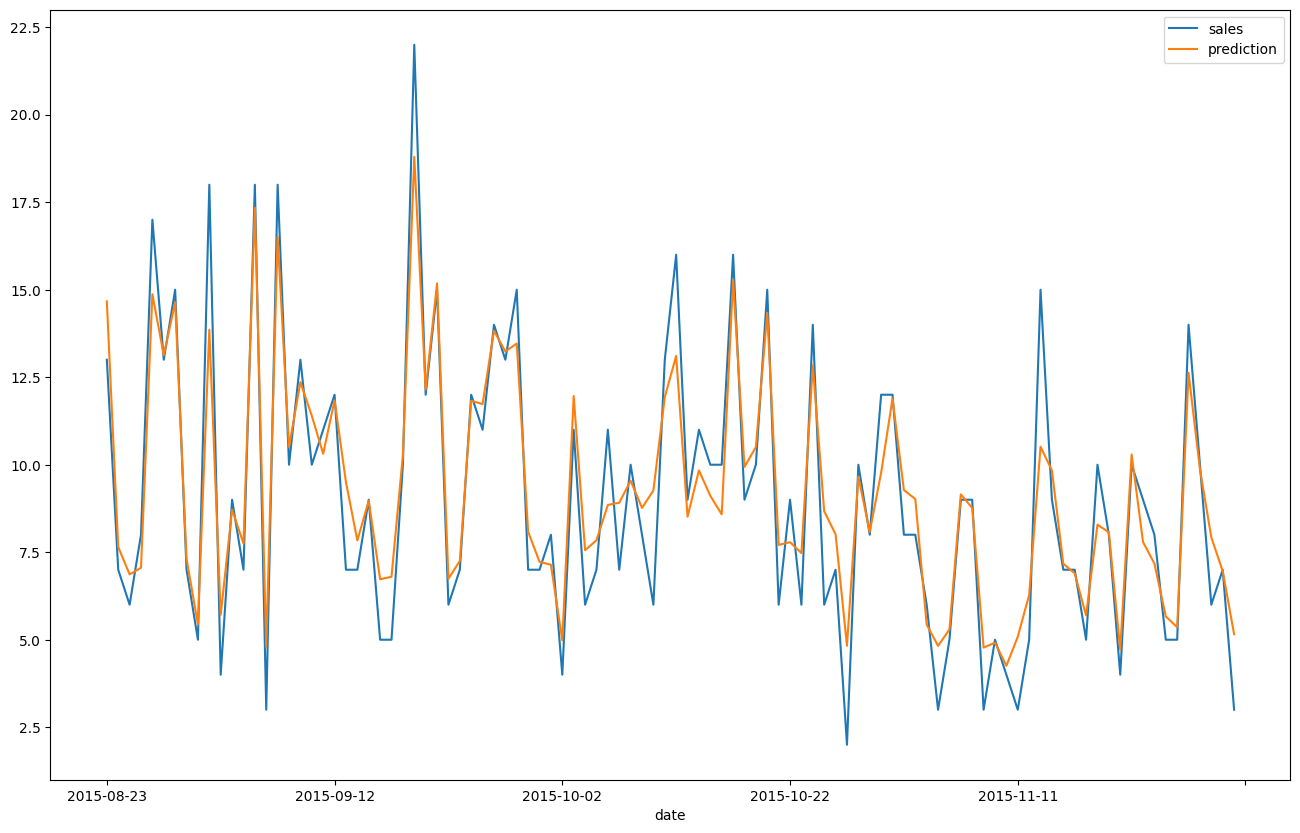

In [23]:
temp.tail(100).plot(figsize = (16,10));

## SCALE FOR ALL PRODUCTS

The process works, now we need to scale it to all the store-product combinations

In [37]:
x = pd.read_parquet(TRANSFORMED_DATA_DIR / 'x_preselection.parquet')
y = pd.read_parquet(TRANSFORMED_DATA_DIR / 'y_preselection.parquet')

Include as a new variable the store-product combinations

In [38]:
x.insert(loc=0,column='product',value=x.store_id + '_'+ x.item_id)
x = x.drop(columns = ['store_id','item_id'])

In [39]:
x

product        date  sales_mm_7  sales_mm_8  sales_mm_6  \
0      CA_3_FOODS_3_090  2013-01-16      236.00      233.38      242.50   
1      CA_3_FOODS_3_090  2013-01-17      235.14      230.38      233.50   
2      CA_3_FOODS_3_090  2013-01-18      224.43      227.00      226.17   
3      CA_3_FOODS_3_090  2013-01-19      225.86      224.38      205.00   
4      CA_3_FOODS_3_090  2013-01-20      227.43      242.88      218.50   
...                 ...         ...         ...         ...         ...   
20975  CA_4_FOODS_3_714  2015-11-26        9.86        9.38       10.67   
20976  CA_4_FOODS_3_714  2015-11-27       12.29       11.38       11.83   
20977  CA_4_FOODS_3_714  2015-11-28       11.57       12.00       11.33   
20978  CA_4_FOODS_3_714  2015-11-29       12.14       12.25       11.67   
20979  CA_4_FOODS_3_714  2015-11-30       11.00       11.50       12.33   

       sales_mm_9  sales_mm_2  sales_mm_10  sales_mm_5  sales_mm_3  ...  \
0          228.33      182.00       232.50      242.00      215.00  ...   
1          228.67      174.50       224.60      237.40      185.00  ...   
2          223.67      180.50       222.80      201.20      173.00  ...   
3          226.67      197.00       223.70      189.80      195.00  ...   
4          239.67      293.00       240.20      221.00      252.00  ...   
...           ...         ...          ...         ...         ...  ...   
20975        9.67        9.00         9.50        9.80        7.00  ...   
20976       10.78       14.00        10.90       11.60       13.33  ...   
20977       11.22       16.00        10.70       10.60       12.67  ...   
20978       12.56       13.50        11.80       13.40       16.33  ...   
20979       11.67       12.00        12.00       12.40       11.33  ...   

       sell_price_lag_7  sell_price_lag_5  stock_break_3_lag_1  \
0                  1.25              1.25                 0.00   
1                  1.25              1.25                 0.00   
2                  1.25              1.25                 0.00   
3                  1.25              1.25                 0.00   
4                  1.25              1.25                 0.00   
...                 ...               ...                  ...   
20975              1.58              1.58                 0.00   
20976              1.58              1.58                 0.00   
20977              1.58              1.58                 0.00   
20978              1.58              1.58                 0.00   
20979              1.58              1.58                 0.00   

       stock_break_7_lag_1  stock_break_15_lag_1  weekday_te  wday_te  \
0                     0.00                  0.00       24.89    24.89   
1                     0.00                  0.00       26.10    26.10   
2                     0.00                  0.00       29.48    29.48   
3                     0.00                  0.00       34.80    34.80   
4                     0.00                  0.00       34.39    34.39   
...                    ...                   ...         ...      ...   
20975                 0.00                  0.00       26.10    26.10   
20976                 0.00                  0.00       29.48    29.48   
20977                 0.00                  0.00       34.80    34.80   
20978                 0.00                  0.00       34.39    34.39   
20979                 0.00                  0.00       27.07    27.07   

       weekday_Wednesday  month_11  weekday_Saturday  
0                   1.00      0.00              0.00  
1                   0.00      0.00              0.00  
2                   0.00      0.00              0.00  
3                   0.00      0.00              1.00  
4                   0.00      0.00              0.00  
...                  ...       ...               ...  
20975               0.00      1.00              0.00  
20976               0.00      1.00              0.00  
20977               0.00      1.00              1

In [45]:
y

index  sales
0          0    191
1          1    170
2          2    224
3          3    362
4          4    255
...      ...    ...
20975  20975     22
20976  20976     10
20977  20977     17
20978  20978      7
20979  20979      9

[20980 rows x 2 columns]

To be able to apply the process repeatedly, we are going to create a list where each element contains the data for each product.

In [40]:
products = list(x.groupby("product"))
products

[('CA_3_FOODS_3_090',
                 product        date  sales_mm_7  sales_mm_8  sales_mm_6  \
  0     CA_3_FOODS_3_090  2013-01-16      236.00      233.38      242.50   
  1     CA_3_FOODS_3_090  2013-01-17      235.14      230.38      233.50   
  2     CA_3_FOODS_3_090  2013-01-18      224.43      227.00      226.17   
  3     CA_3_FOODS_3_090  2013-01-19      225.86      224.38      205.00   
  4     CA_3_FOODS_3_090  2013-01-20      227.43      242.88      218.50   
  ...                ...         ...         ...         ...         ...   
  1044  CA_3_FOODS_3_090  2015-11-26      139.43      134.50      151.50   
  1045  CA_3_FOODS_3_090  2015-11-27      166.43      154.00      172.67   
  1046  CA_3_FOODS_3_090  2015-11-28      157.71      154.12      160.67   
  1047  CA_3_FOODS_3_090  2015-11-29      150.43      149.12      156.83   
  1048  CA_3_FOODS_3_090  2015-11-30      143.29      139.38      151.33   
  
        sales_mm_9  sales_mm_2  sales_mm_10  sales_mm_5  sales_

We encapsulate the individual modeling process in a function, which we will call for each product.

In [41]:
y

index  sales
0          0    191
1          1    170
2          2    224
3          3    362
4          4    255
...      ...    ...
20975  20975     22
20976  20976     10
20977  20977     17
20978  20978      7
20979  20979      9

[20980 rows x 2 columns]

In [33]:
y_sales

7343     6
7344    13
7345     8
7346    13
7347    13
        ..
8387    14
8388    10
8389     6
8390     7
8391     3
Name: sales, Length: 1049, dtype: int64

In [42]:
# Receives the x and y data for each product

def modelize(x_product, y):
          
    # Excludes the product as a modeling variable
    var_modelize = x_product.columns.to_list()[2:]
    
    # Defines the cross-validation
    time_cv = TimeSeriesSplit(3, test_size=8)
    
    # Defines the pipeline of algorithms
    pipe = Pipeline([('algorithm', HistGradientBoostingRegressor())])
    grid = [ 
         {'algorithm': [HistGradientBoostingRegressor()]
#          'algorithm__learning_rate': [0.01, 0.025, 0.05, 0.1],
#          'algorithm__max_iter': [50, 100, 200],
#          'algorithm__max_depth': [5, 10, 20, 50],
#          'algorithm__scoring': ['neg_mean_absolute_error'],
#          'algorithm__l2_regularization': [0, 0.25, 0.5, 0.75, 1]
         }
    ]
           
    # Creates the models
    random_search = RandomizedSearchCV(estimator=pipe,
                                   param_distributions=grid, 
                                   n_iter=1, 
                                   cv=time_cv, 
                                   scoring='neg_mean_absolute_error', 
                                   verbose=0,
                                   n_jobs=-1)
    
    model = random_search.fit(x_product[var_modelize], y)
    
    # Retrains the best model on all the data
    final_model = model.best_estimator_.fit(x_product[var_modelize], y)
    
    # Returns the final model as output
    return(final_model)

We create another empty list where we will store the trained models for each product.

In [43]:
models_list = []

In [46]:
y_each = y[y.index.isin(data.index)]['sales']  # Extract the 'sales' column

In [47]:
y_each 

0       191
1       170
2       224
3       362
4       255
       ... 
1044    256
1045     68
1046     89
1047     62
1048     61
Name: sales, Length: 1049, dtype: int64

We iterate through each element of the product list and fill the `models_list` with the name and final model of each product.

In [48]:
for each in products:
    # Rename for clarity
    product = each[0]
    data = each[1]
    
    # Select only the data of the target variable that corresponds to the product
    y_each = y[y.index.isin(data.index)]['sales']  # Ensure y_each is a 1D array

    # Call the modelize function
    model = modelize(data, y_each)

    # Add the final model to the list
    models_list.append((product, model))

In [57]:
models_list

[('CA_3_FOODS_3_090',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_120',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_202',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_252',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_288',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_329',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_555',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_586',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_587',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_3_FOODS_3_714',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),
 ('CA_4_FOODS_3_090',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])),

Check. 

The goal is to check the process works and there's nothing weird. 

We are not using the training data, just checking.

In [52]:
# Join the df to extract the x and y of each produtc
df =  pd.concat([x,y],axis=1)
df

product        date  sales_mm_7  sales_mm_8  sales_mm_6  \
0      CA_3_FOODS_3_090  2013-01-16      236.00      233.38      242.50   
1      CA_3_FOODS_3_090  2013-01-17      235.14      230.38      233.50   
2      CA_3_FOODS_3_090  2013-01-18      224.43      227.00      226.17   
3      CA_3_FOODS_3_090  2013-01-19      225.86      224.38      205.00   
4      CA_3_FOODS_3_090  2013-01-20      227.43      242.88      218.50   
...                 ...         ...         ...         ...         ...   
20975  CA_4_FOODS_3_714  2015-11-26        9.86        9.38       10.67   
20976  CA_4_FOODS_3_714  2015-11-27       12.29       11.38       11.83   
20977  CA_4_FOODS_3_714  2015-11-28       11.57       12.00       11.33   
20978  CA_4_FOODS_3_714  2015-11-29       12.14       12.25       11.67   
20979  CA_4_FOODS_3_714  2015-11-30       11.00       11.50       12.33   

       sales_mm_9  sales_mm_2  sales_mm_10  sales_mm_5  sales_mm_3  ...  \
0          228.33      182.00       232.50      242.00      215.00  ...   
1          228.67      174.50       224.60      237.40      185.00  ...   
2          223.67      180.50       222.80      201.20      173.00  ...   
3          226.67      197.00       223.70      189.80      195.00  ...   
4          239.67      293.00       240.20      221.00      252.00  ...   
...           ...         ...          ...         ...         ...  ...   
20975        9.67        9.00         9.50        9.80        7.00  ...   
20976       10.78       14.00        10.90       11.60       13.33  ...   
20977       11.22       16.00        10.70       10.60       12.67  ...   
20978       12.56       13.50        11.80       13.40       16.33  ...   
20979       11.67       12.00        12.00       12.40       11.33  ...   

       stock_break_3_lag_1  stock_break_7_lag_1  stock_break_15_lag_1  \
0                     0.00                 0.00                  0.00   
1                     0.00                 0.00                  0.00   
2                     0.00                 0.00                  0.00   
3                     0.00                 0.00                  0.00   
4                     0.00                 0.00                  0.00   
...                    ...                  ...                   ...   
20975                 0.00                 0.00                  0.00   
20976                 0.00                 0.00                  0.00   
20977                 0.00                 0.00                  0.00   
20978                 0.00                 0.00                  0.00   
20979                 0.00                 0.00                  0.00   

       weekday_te  wday_te  weekday_Wednesday  month_11  weekday_Saturday  \
0           24.89    24.89               1.00      0.00              0.00   
1           26.10    26.10               0.00      0.00              0.00   
2           29.48    29.48               0.00      0.00              0.00   
3           34.80    34.80               0.00      0.00              1.00   
4           34.39    34.39               0.00      0.00              0.00   
...           ...      ...                ...       ...               ...   
20975       26.10    26.10               0.00      1.00              0.00   
20976       29.48    29.48               0.00      1.00              0.00   
20977       34.80    34.80               0.00      1.00              1.00   
20978       34.39    34.39               0.00      1.00              0.00   
20979       27.07    27.07               0.00      1.00              0.00   

       index  sales  
0          0    191  
1          1    170  
2          2    224  
3          3    362  
4          4    255  
...      ...    ...  
20975  20975     22  
20976  20976     10  
20977  20977     17  
20978  20978      7  
20979  20979      9  

[20980 rows x 76 columns]

In [53]:
df.columns

Index(['product', 'date', 'sales_mm_7', 'sales_mm_8', 'sales_mm_6',
       'sales_mm_9', 'sales_mm_2', 'sales_mm_10', 'sales_mm_5', 'sales_mm_3',
       'sales_mm_4', 'sales_maxm_7', 'sales_maxm_8', 'sales_mm_11',
       'sales_mm_12', 'sales_maxm_2', 'sales_mm_15', 'sales_lag_1',
       'sales_maxm_6', 'sales_mm_14', 'sales_mm_13', 'sales_maxm_3',
       'sales_maxm_9', 'sales_maxm_4', 'sales_maxm_5', 'sales_maxm_10',
       'sales_maxm_11', 'sales_maxm_14', 'sales_maxm_13', 'sales_maxm_12',
       'sales_maxm_15', 'sales_minm_2', 'sales_minm_3', 'sales_minm_4',
       'sales_minm_6', 'sales_minm_5', 'sales_minm_7', 'sales_lag_2',
       'sales_minm_8', 'sales_lag_7', 'sales_minm_9', 'sales_minm_10',
       'sales_lag_6', 'sales_minm_11', 'sales_lag_3', 'sales_lag_8',
       'sales_lag_4', 'sales_minm_12', 'sales_minm_13', 'sales_lag_5',
       'sales_minm_14', 'sales_minm_15', 'sales_lag_14', 'sales_lag_13',
       'sales_lag_9', 'sales_lag_15', 'sales_lag_12', 'sales_lag_10',
      

In [54]:
print(df.dtypes)

product               object
date                  object
sales_mm_7           float64
sales_mm_8           float64
sales_mm_6           float64
                      ...   
weekday_Wednesday    float64
month_11             float64
weekday_Saturday     float64
index                  int64
sales                  int64
Length: 76, dtype: object


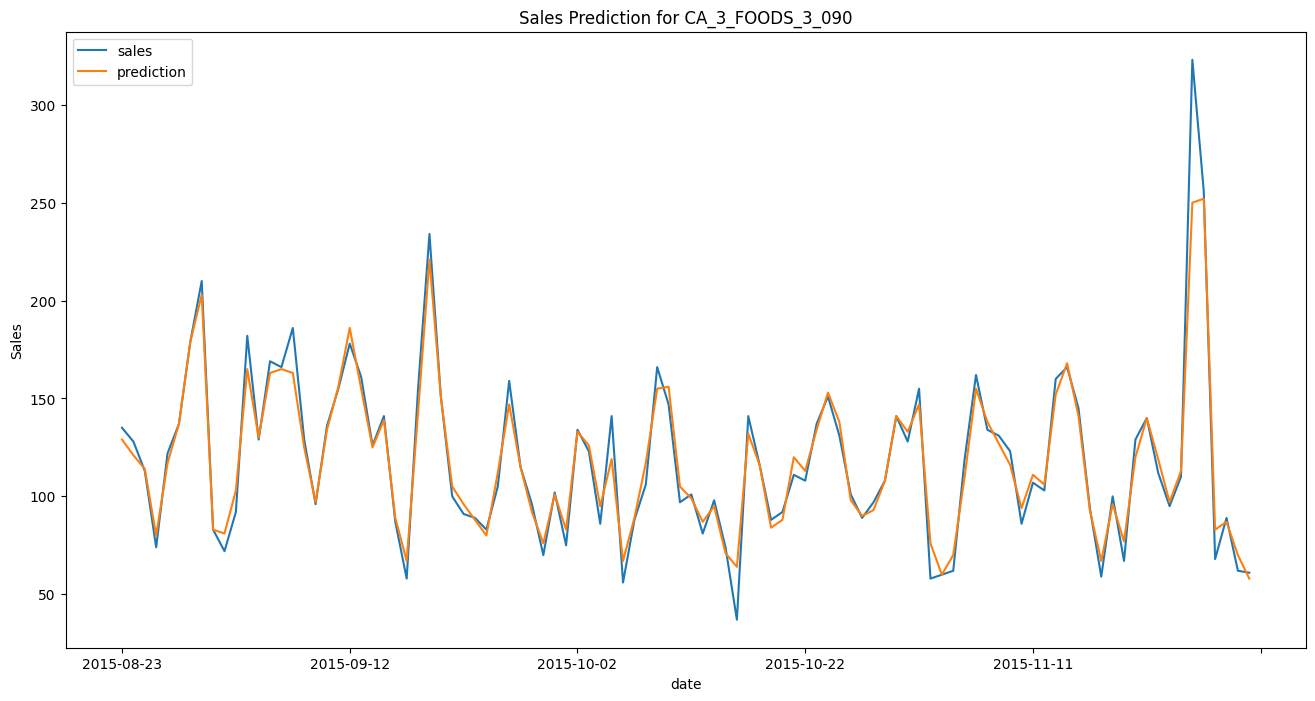

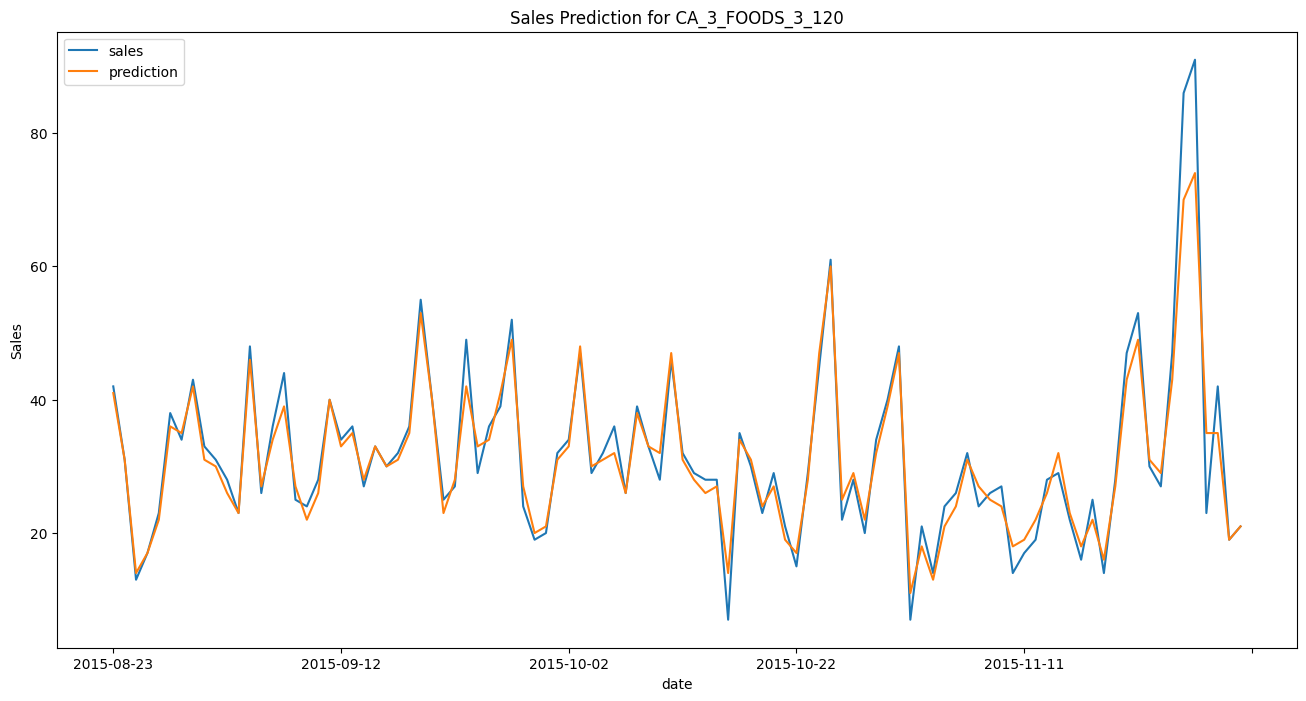

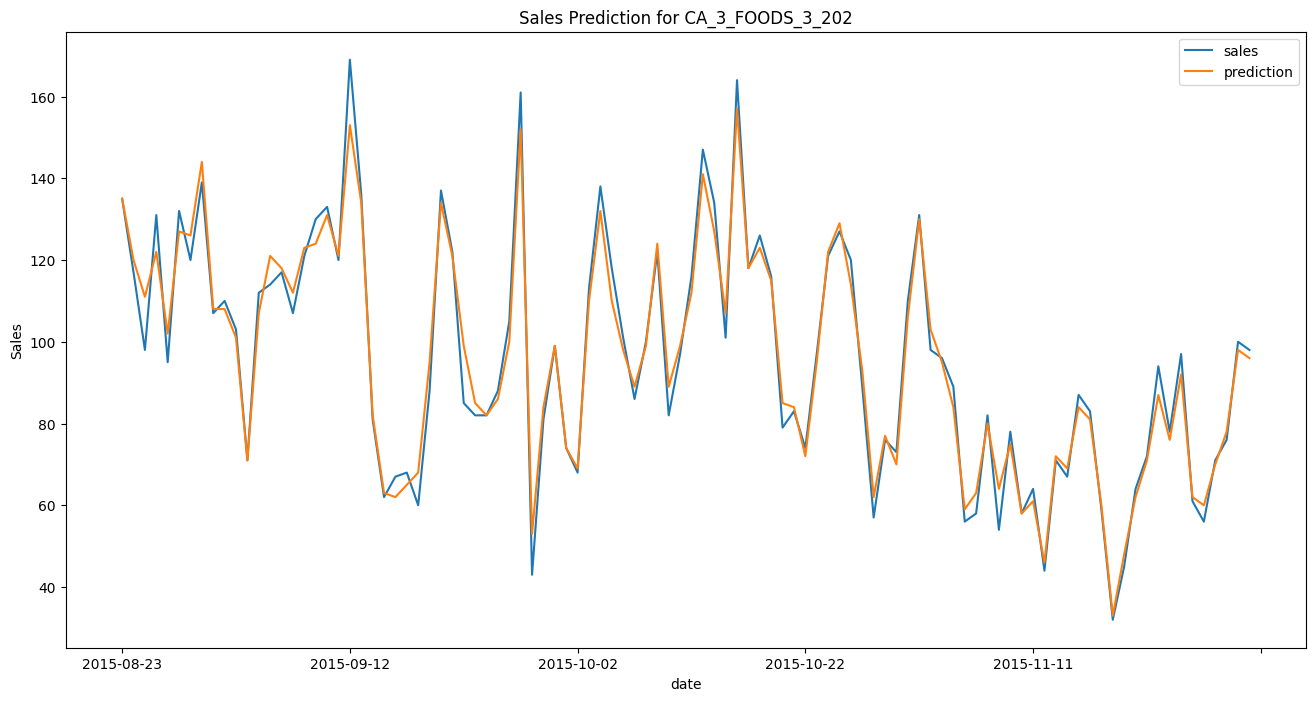

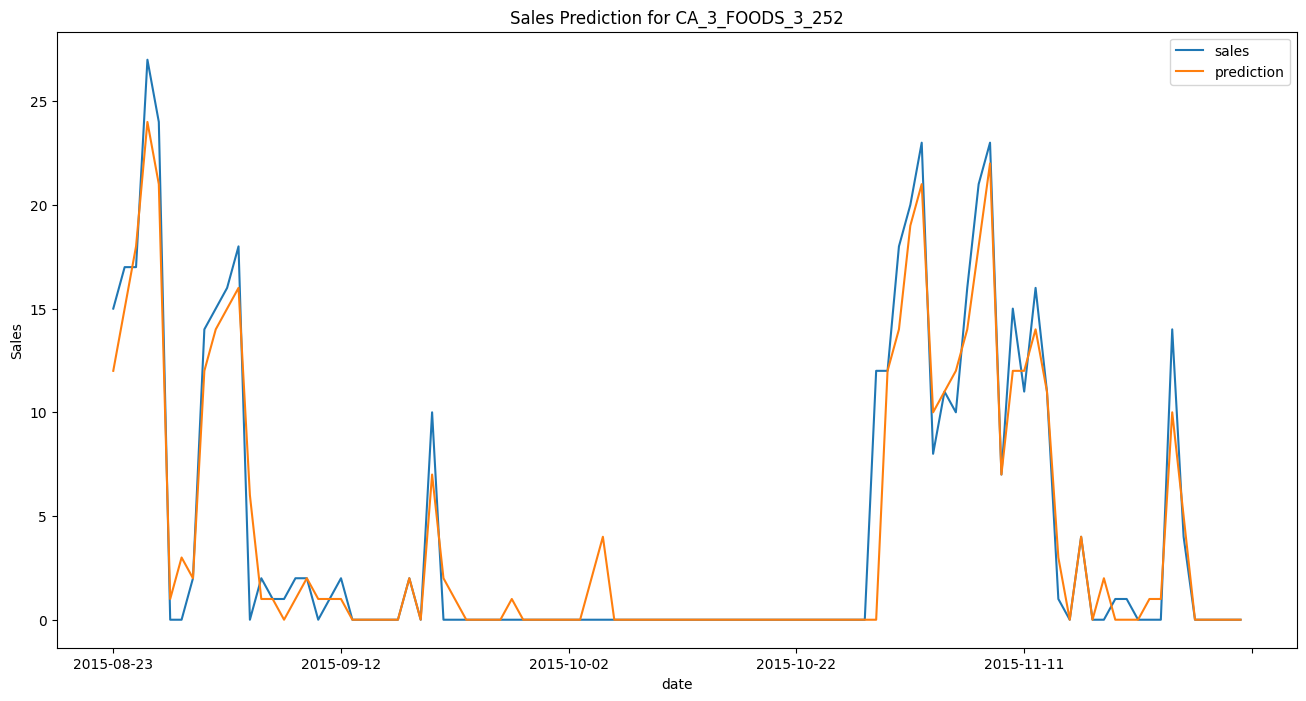

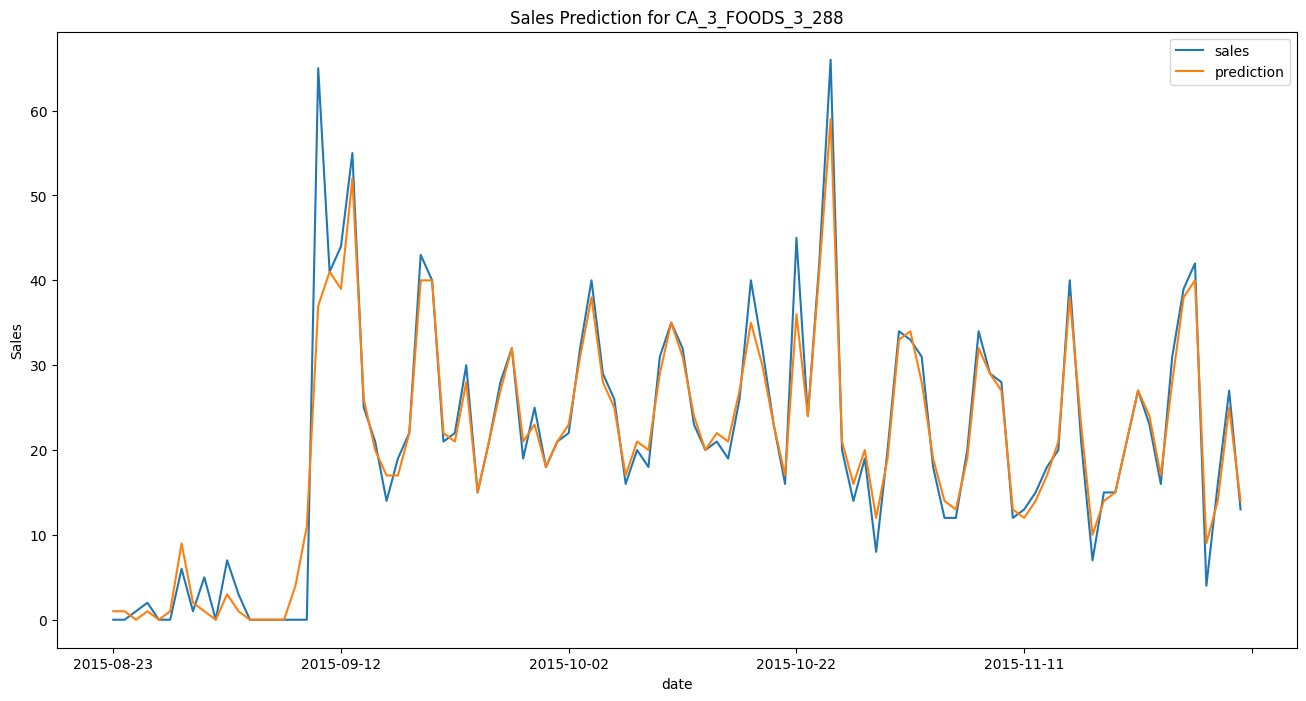

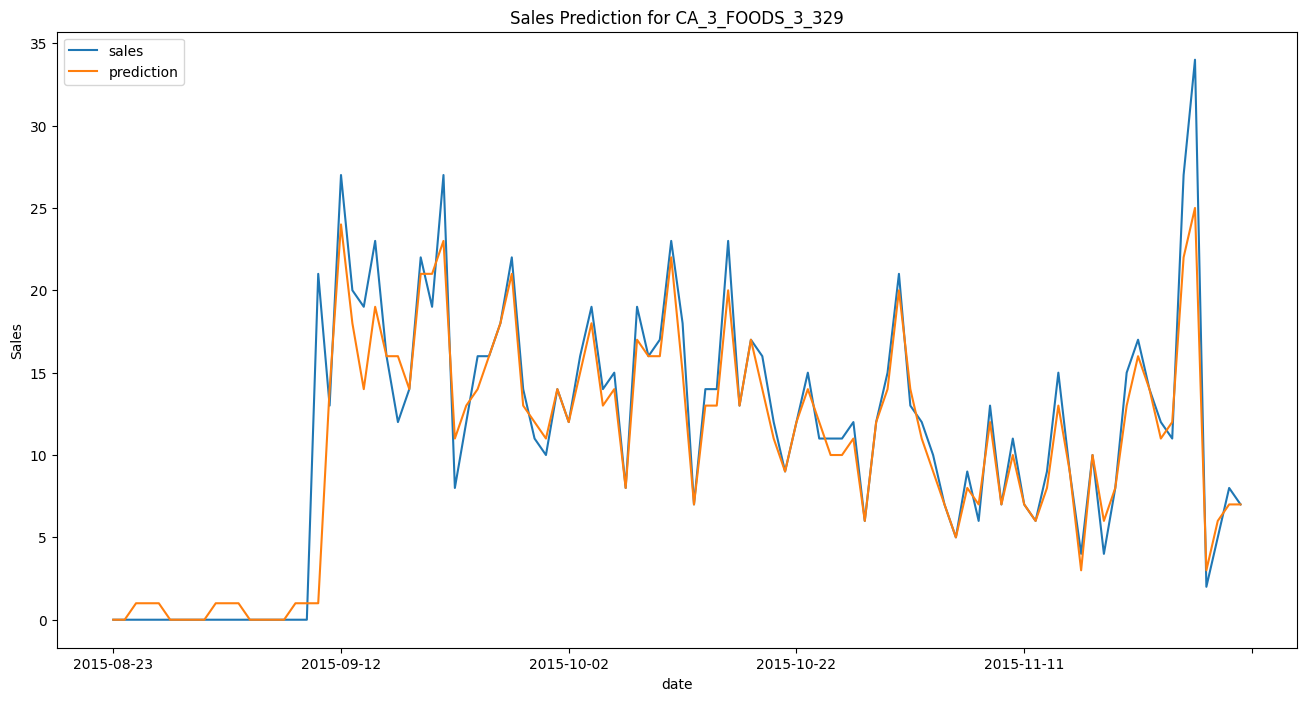

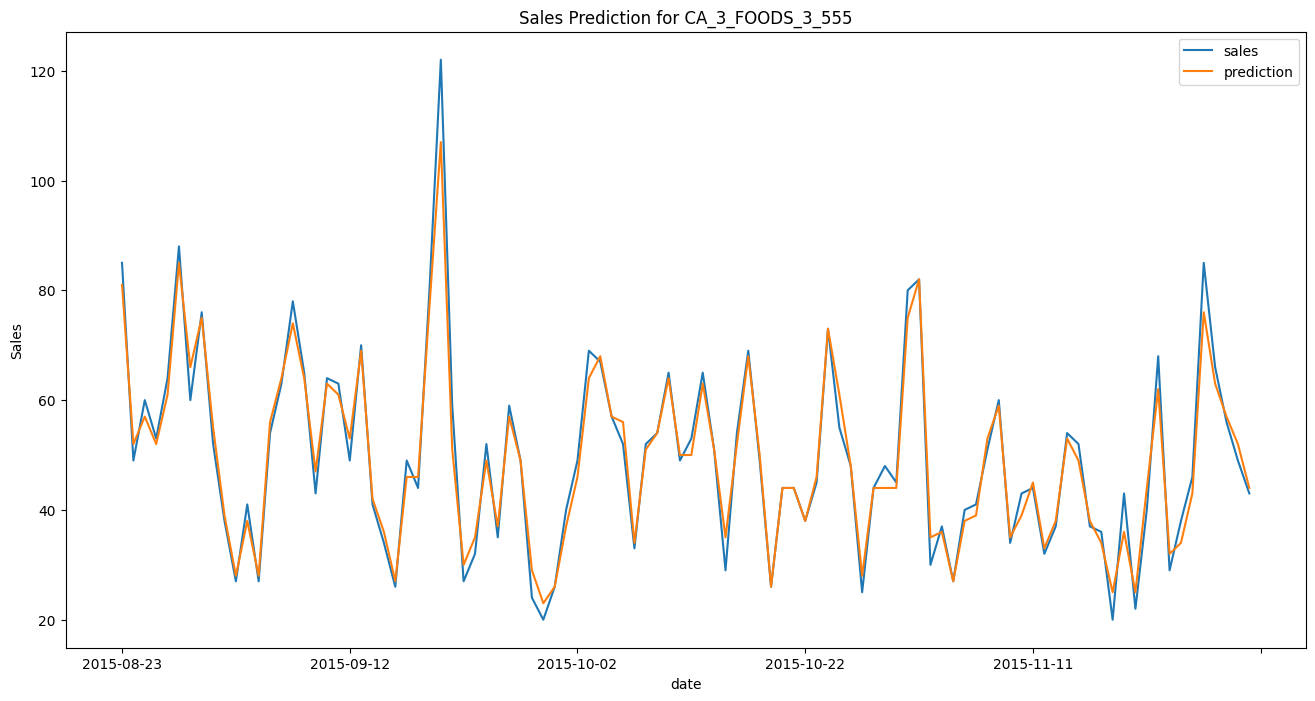

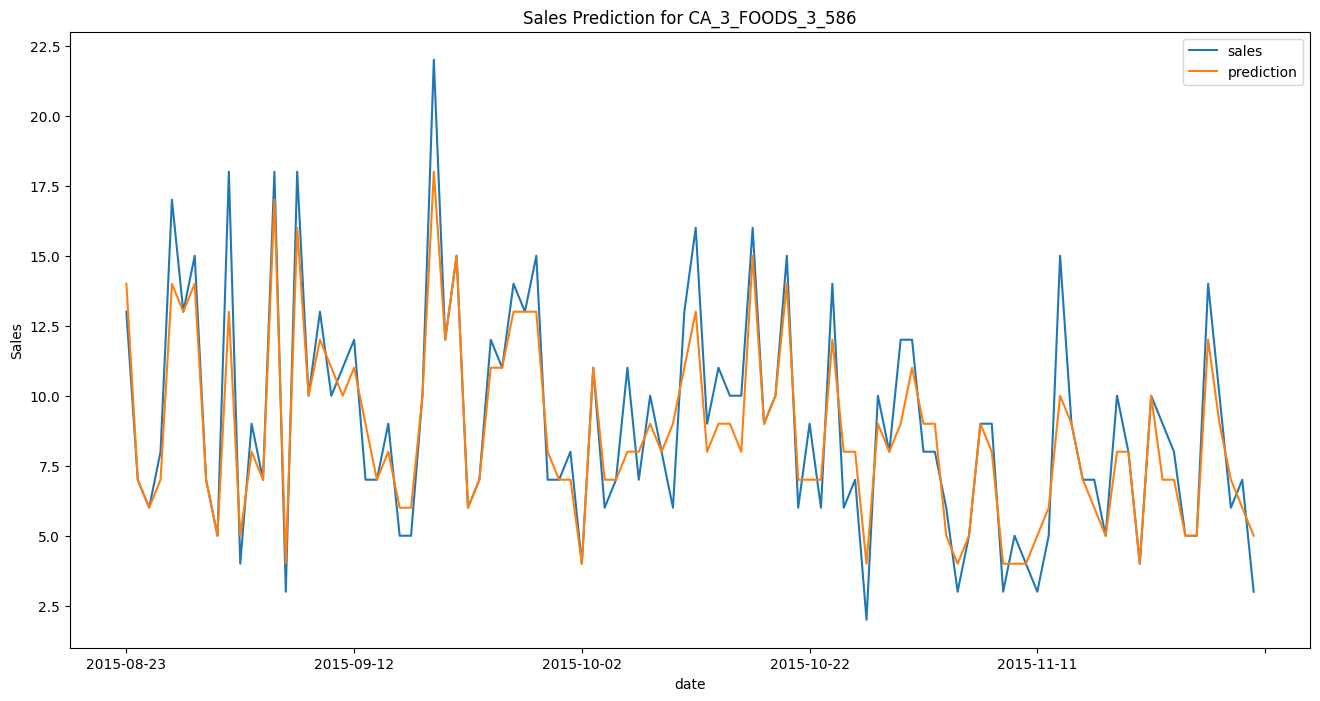

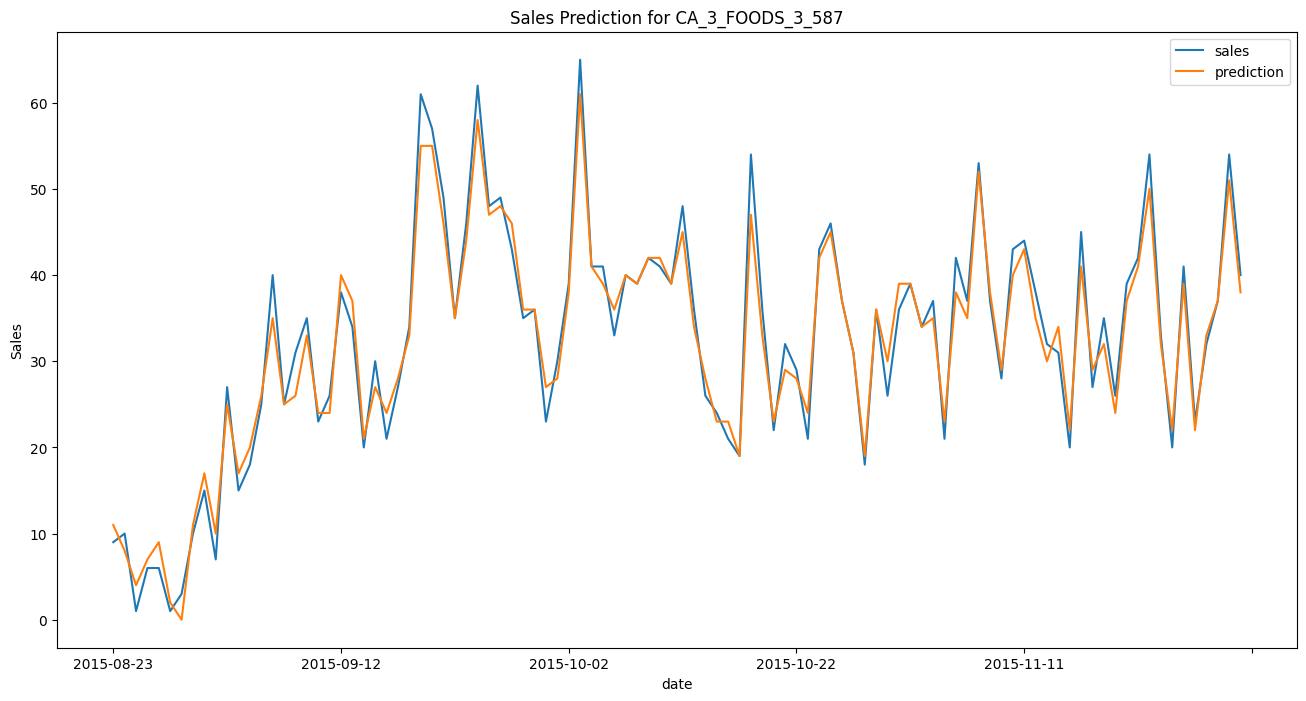

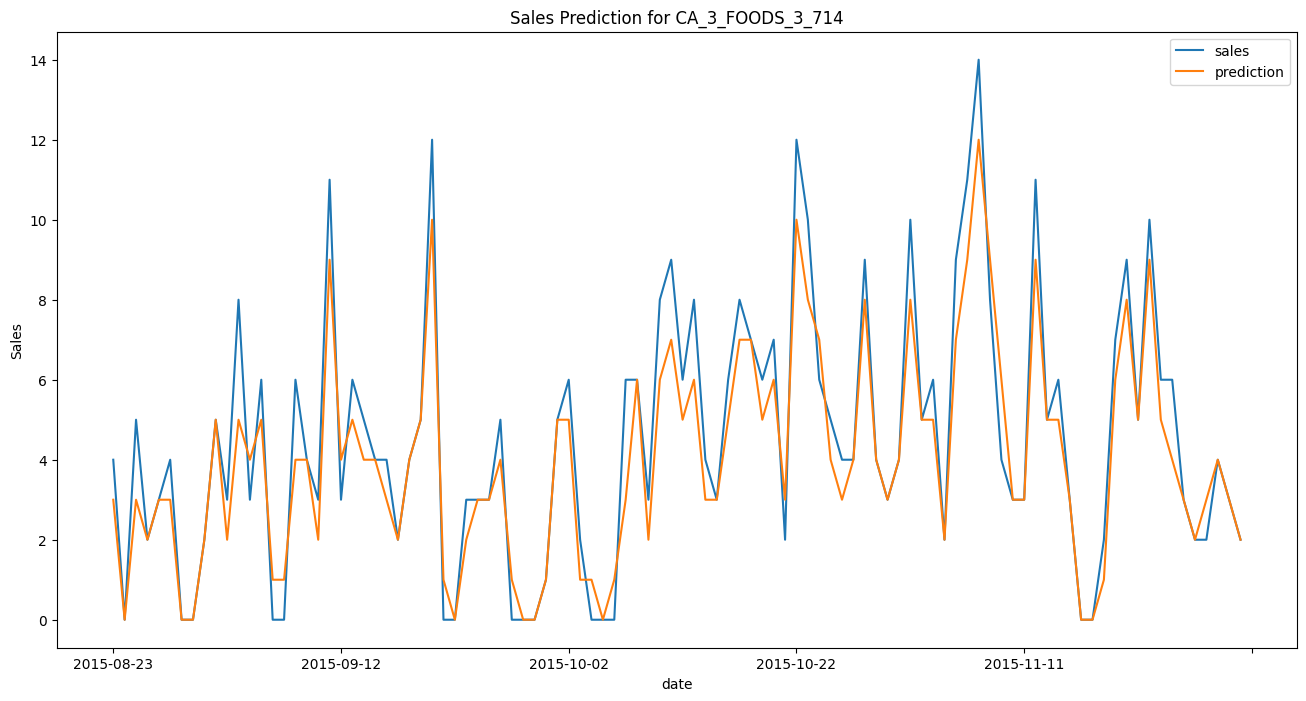

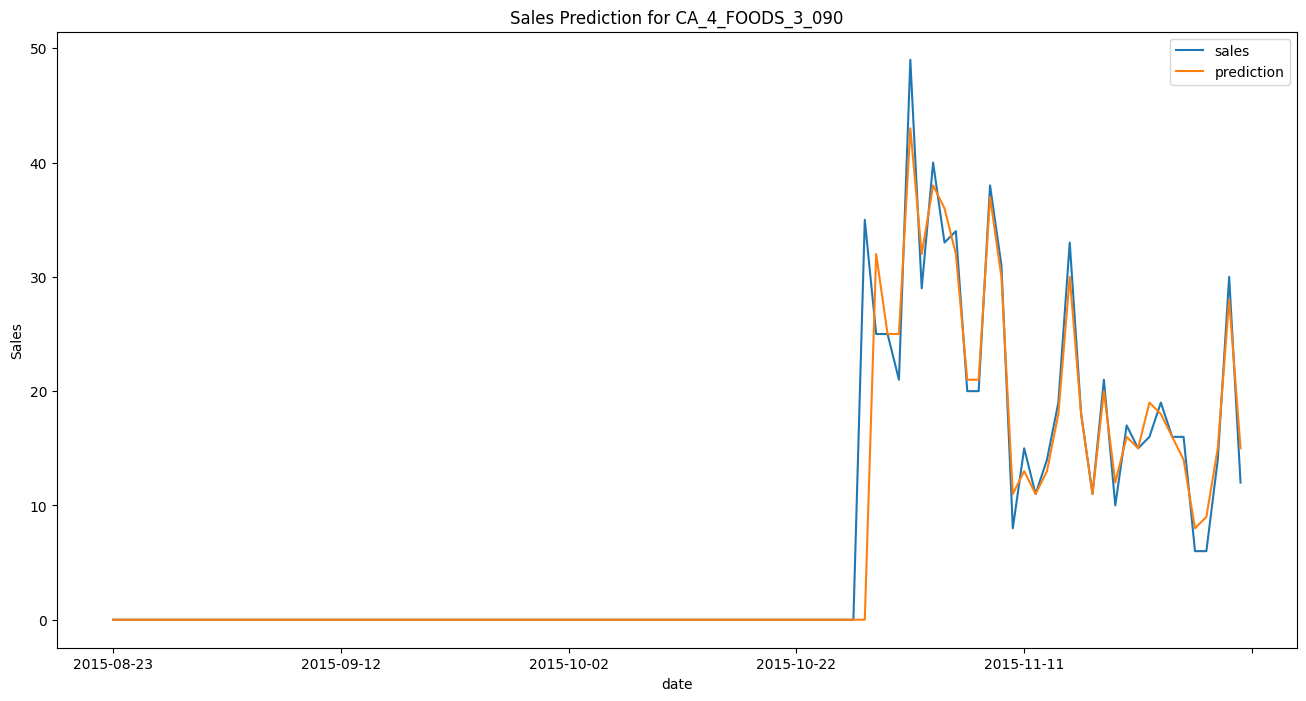

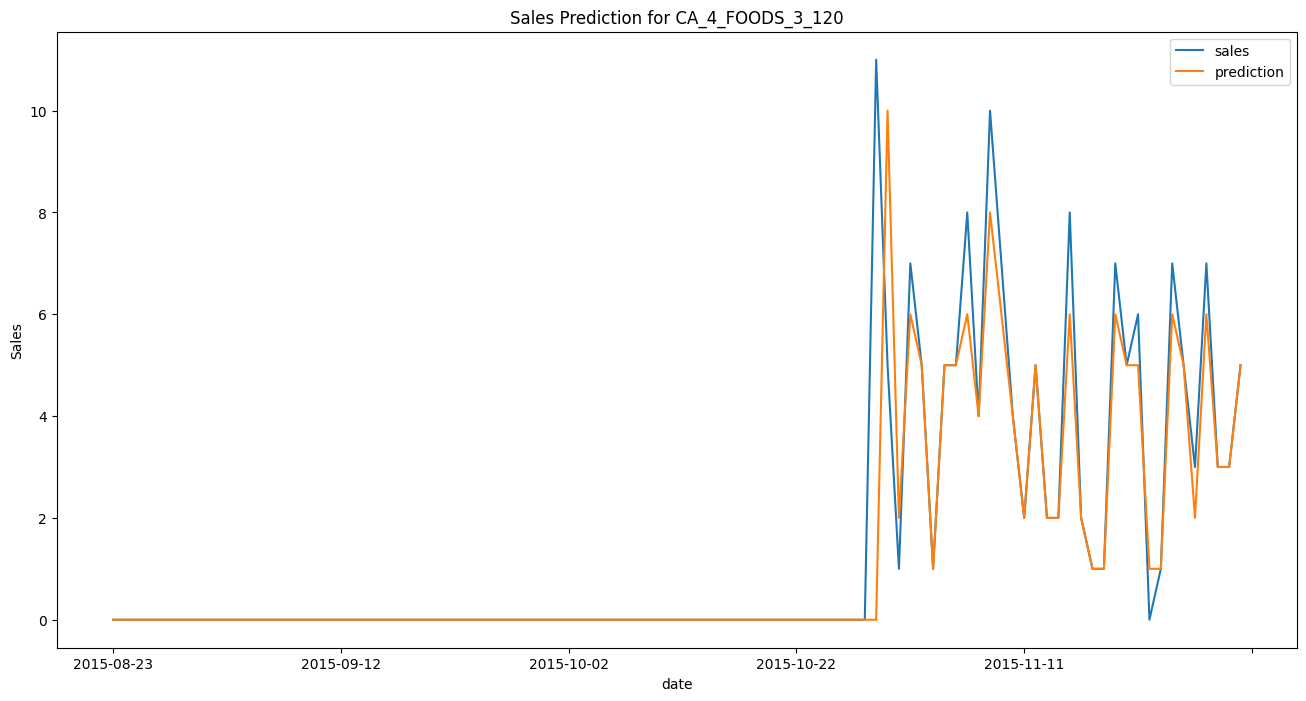

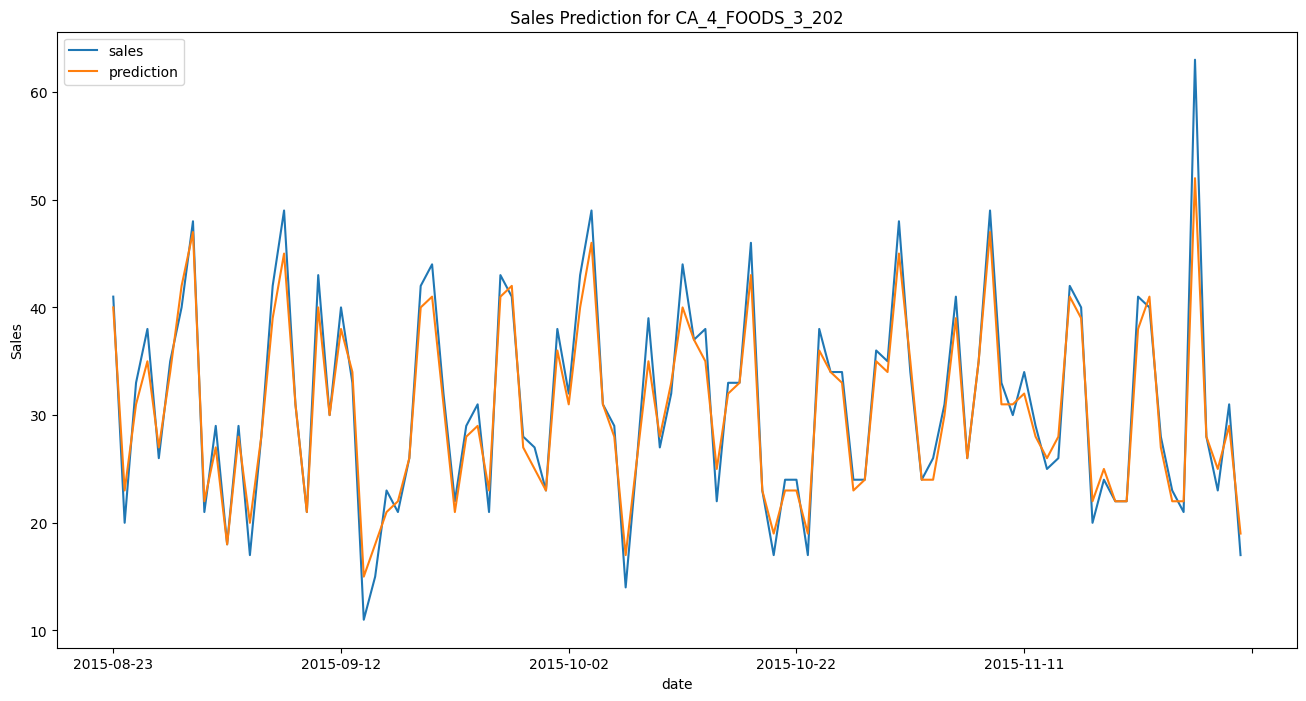

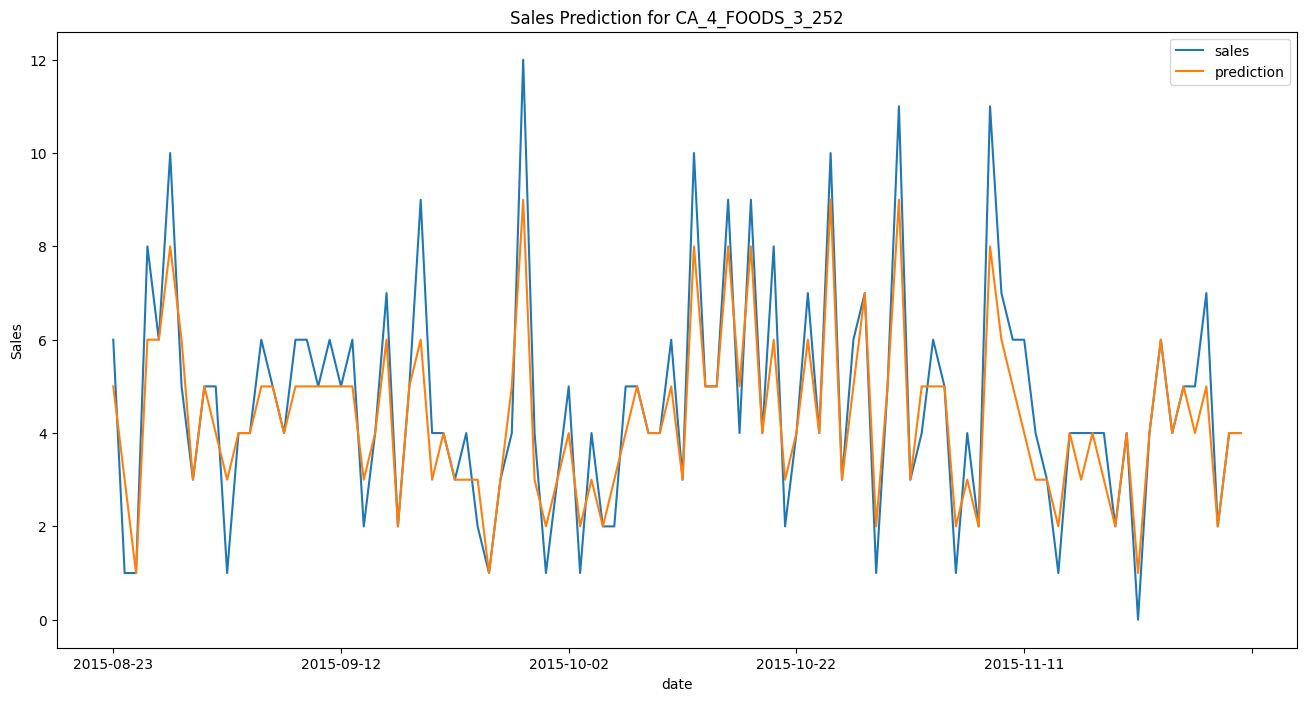

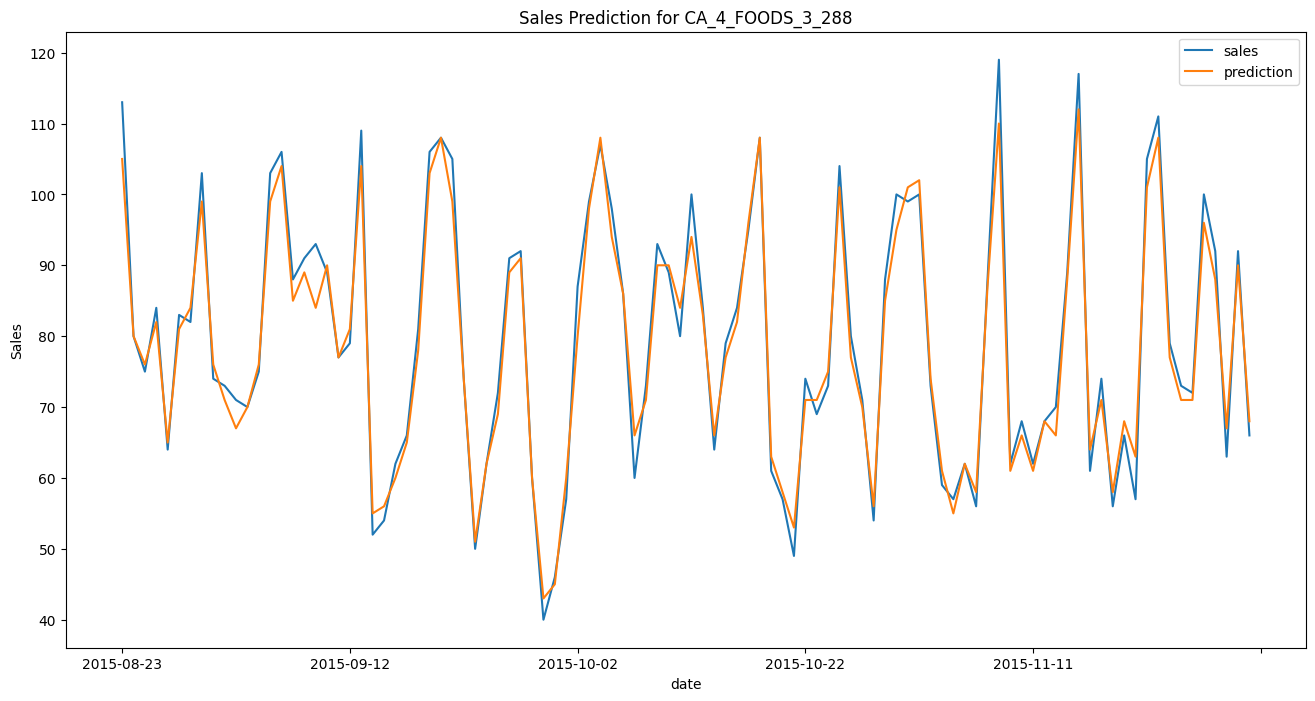

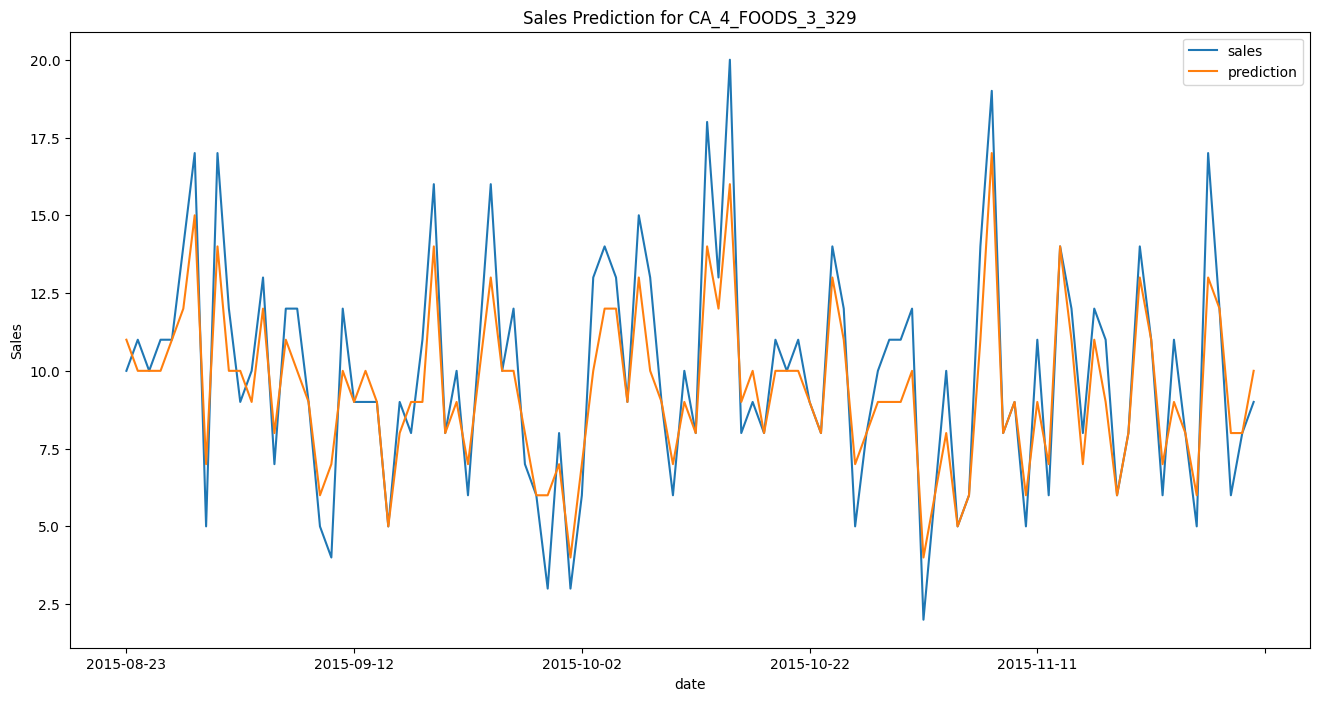

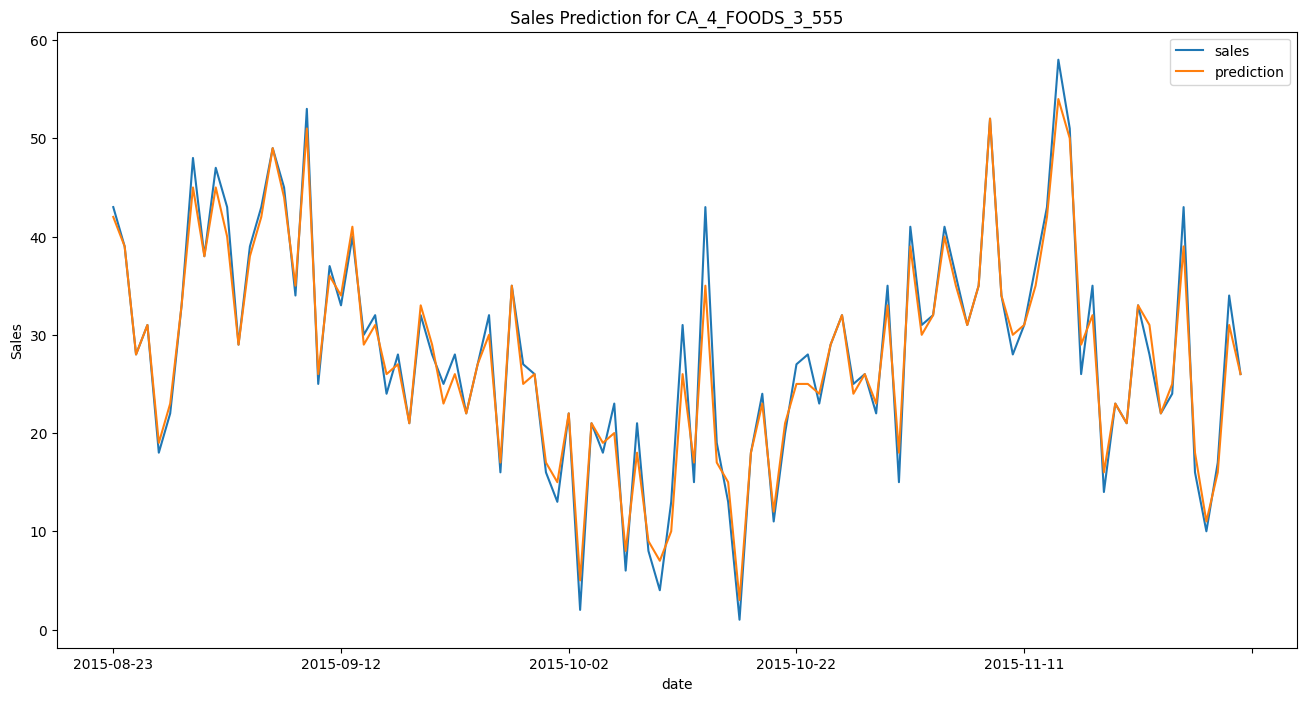

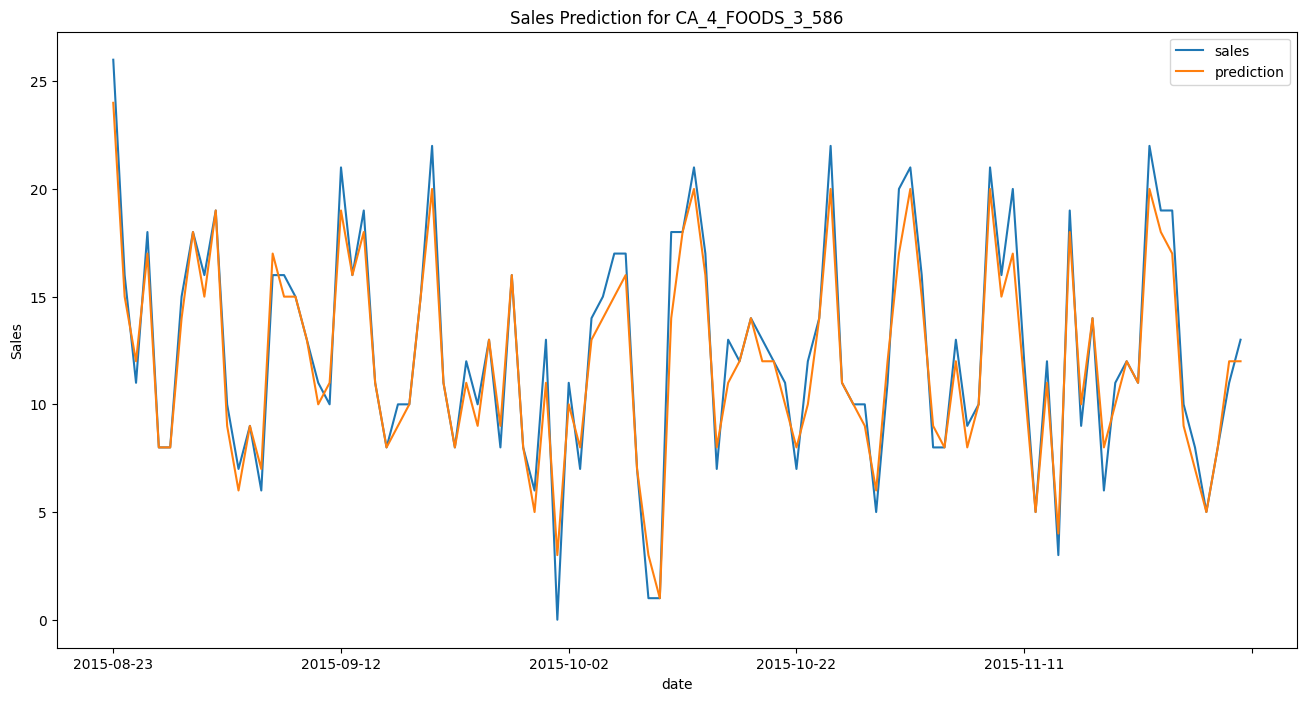

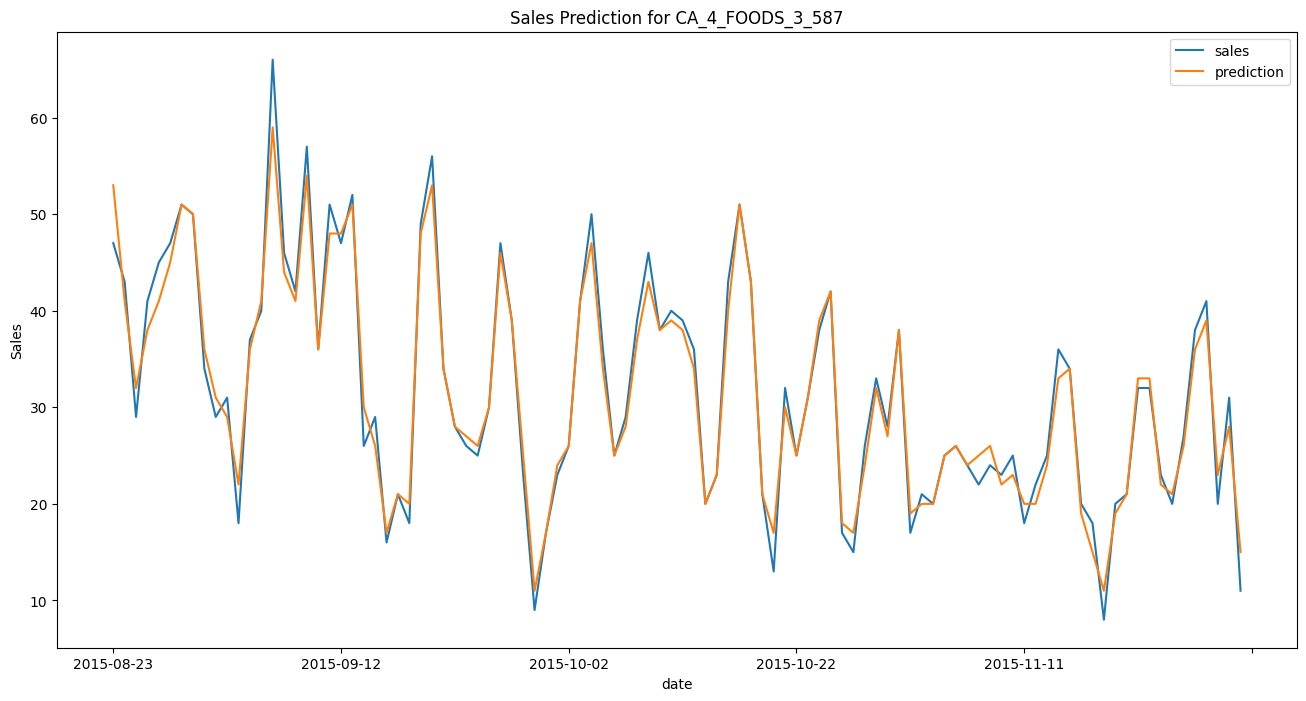

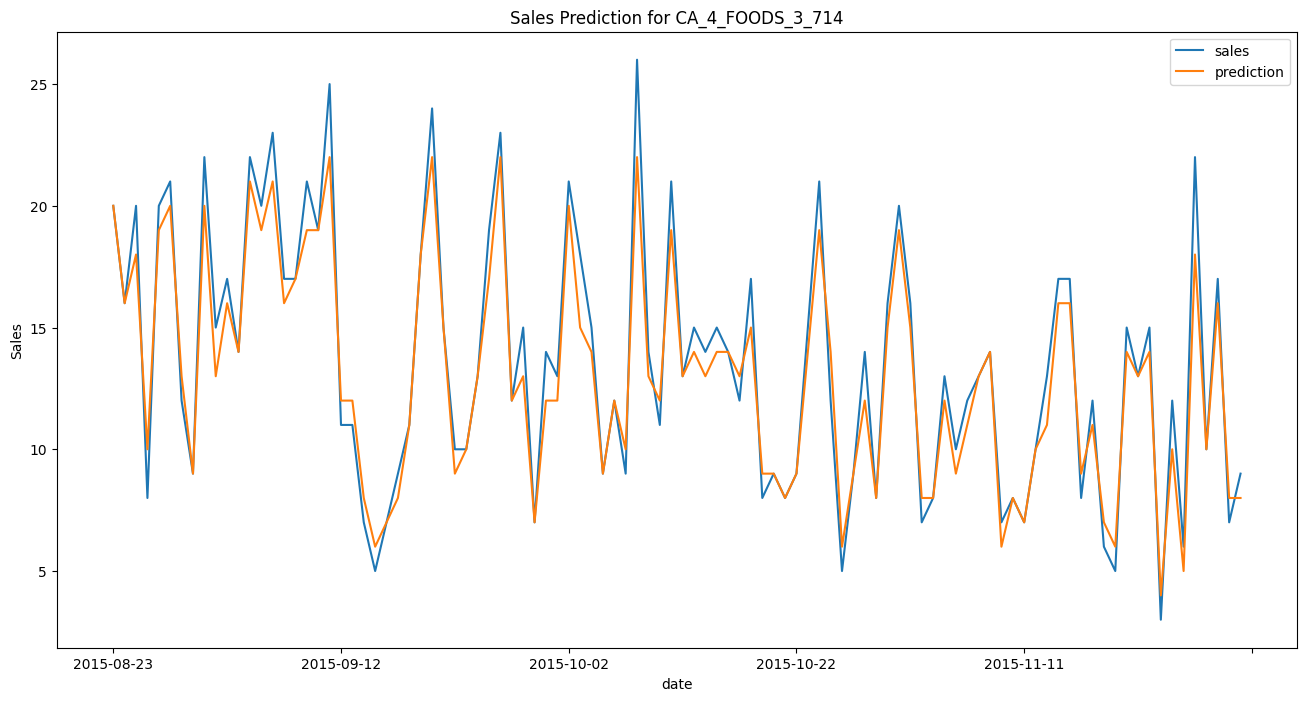

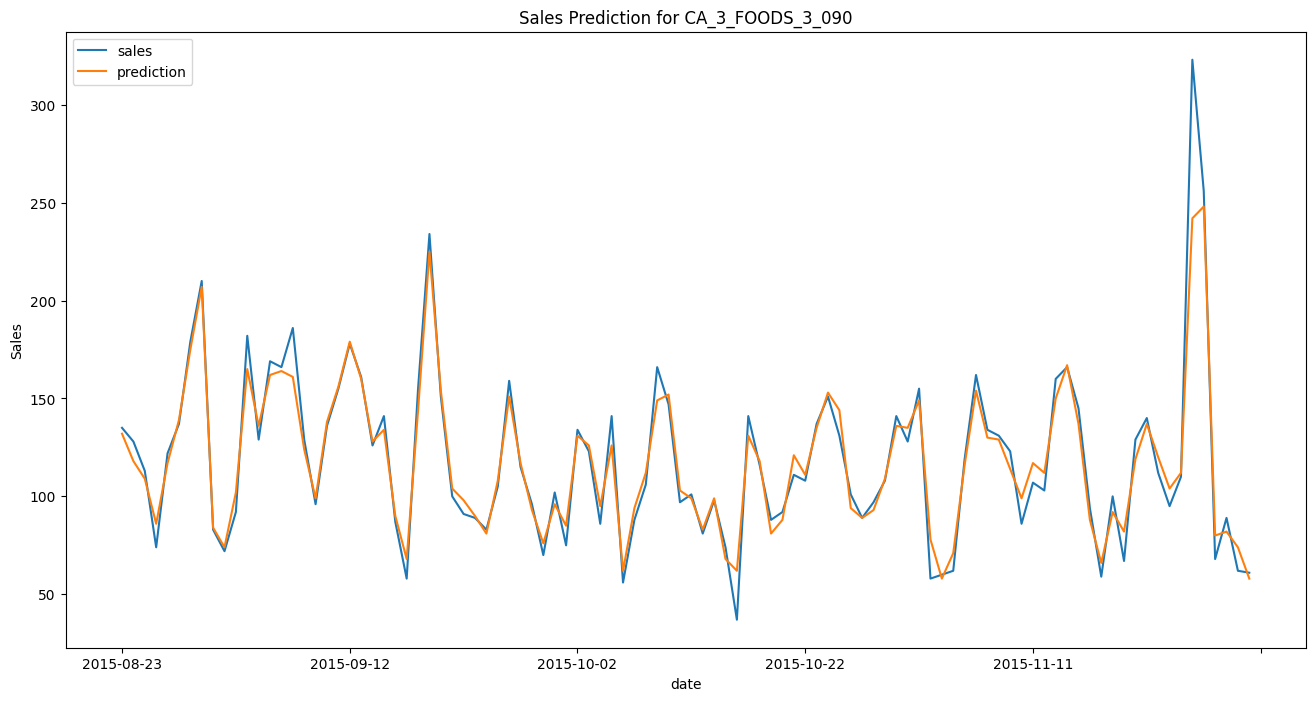

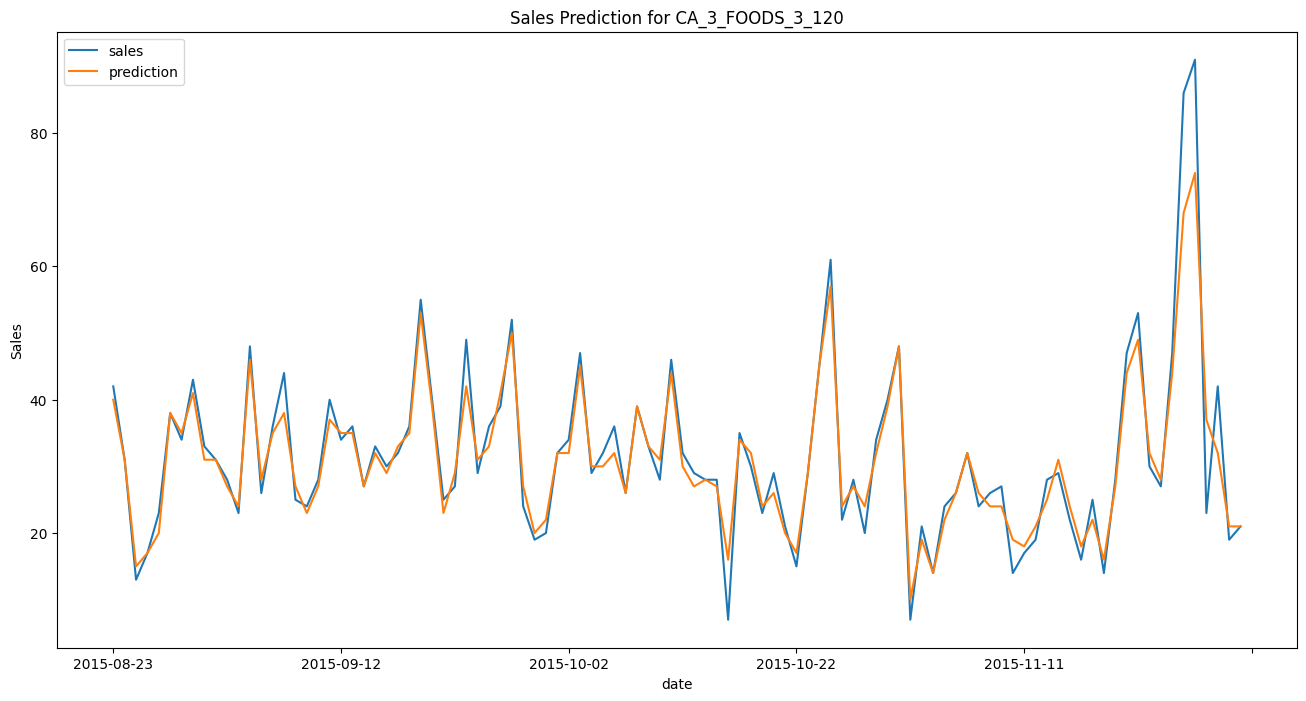

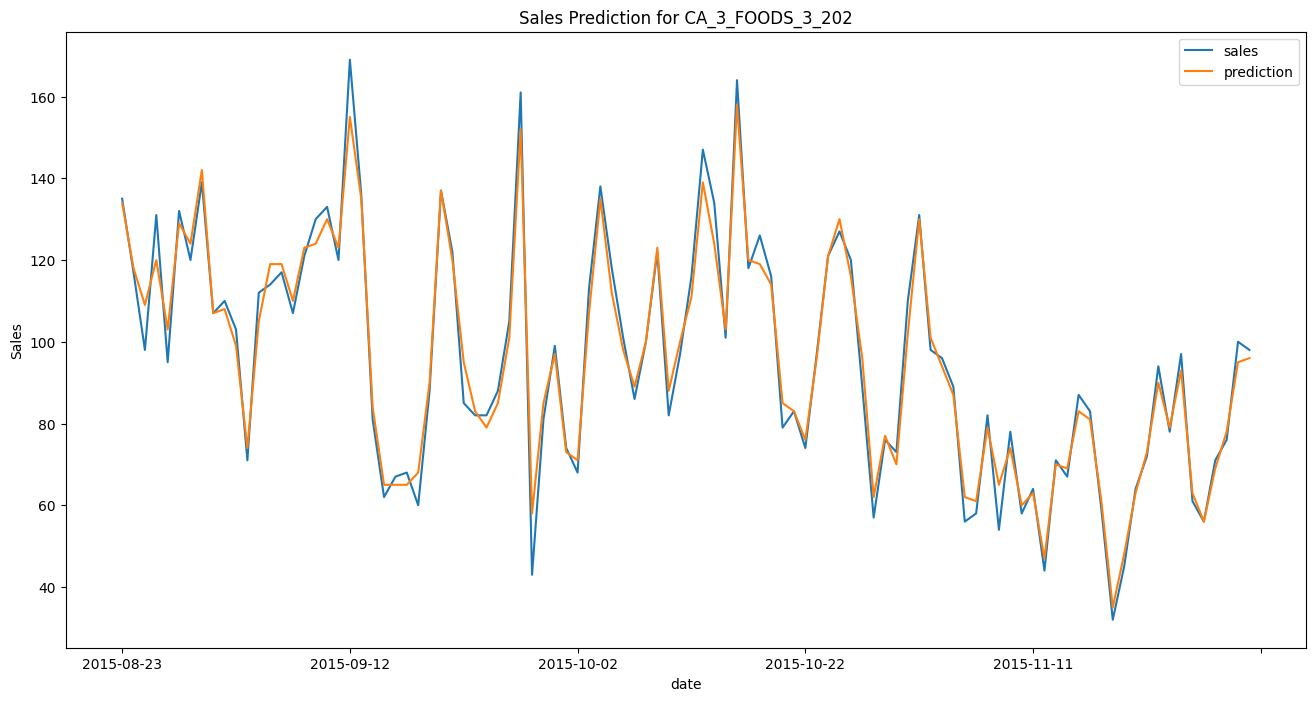

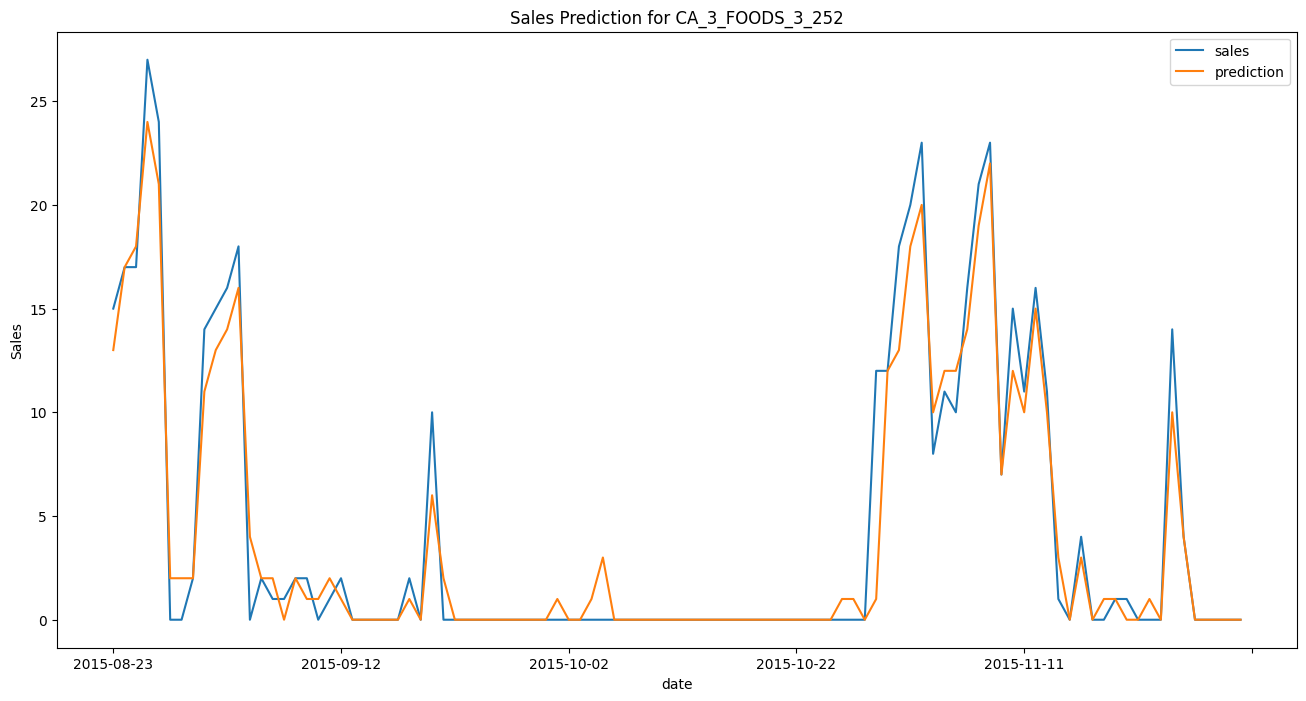

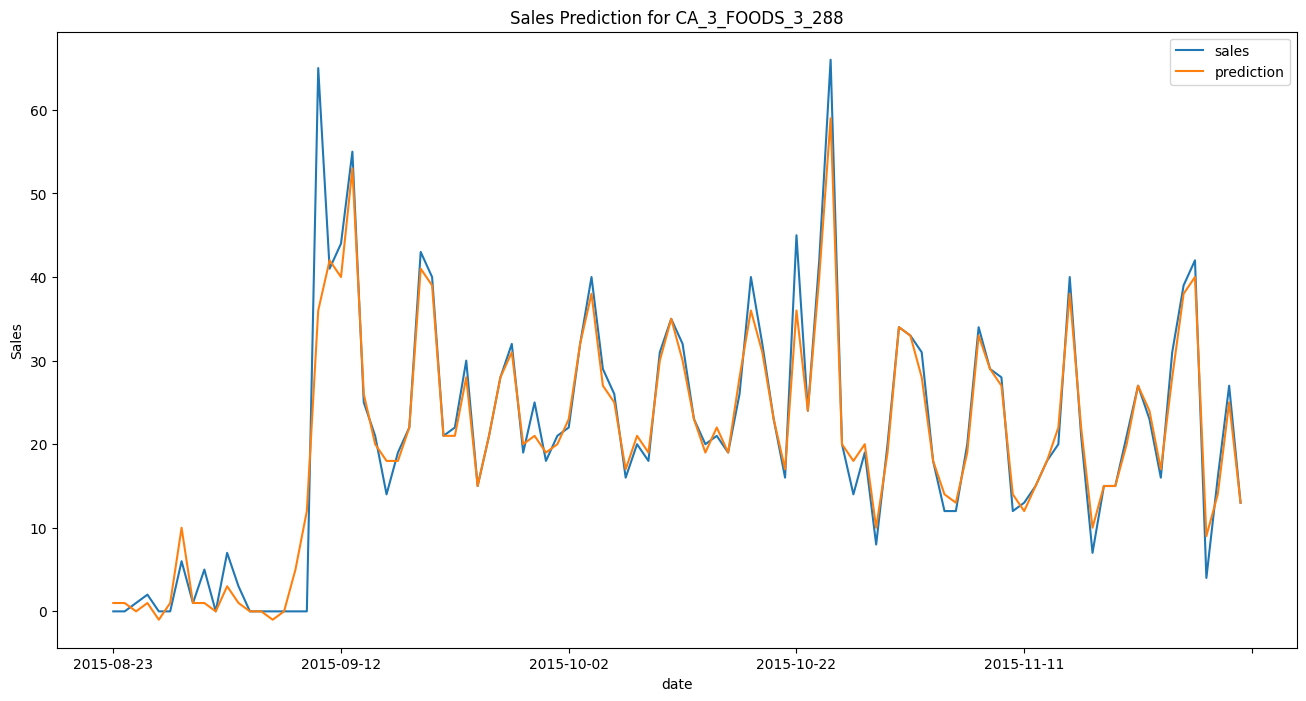

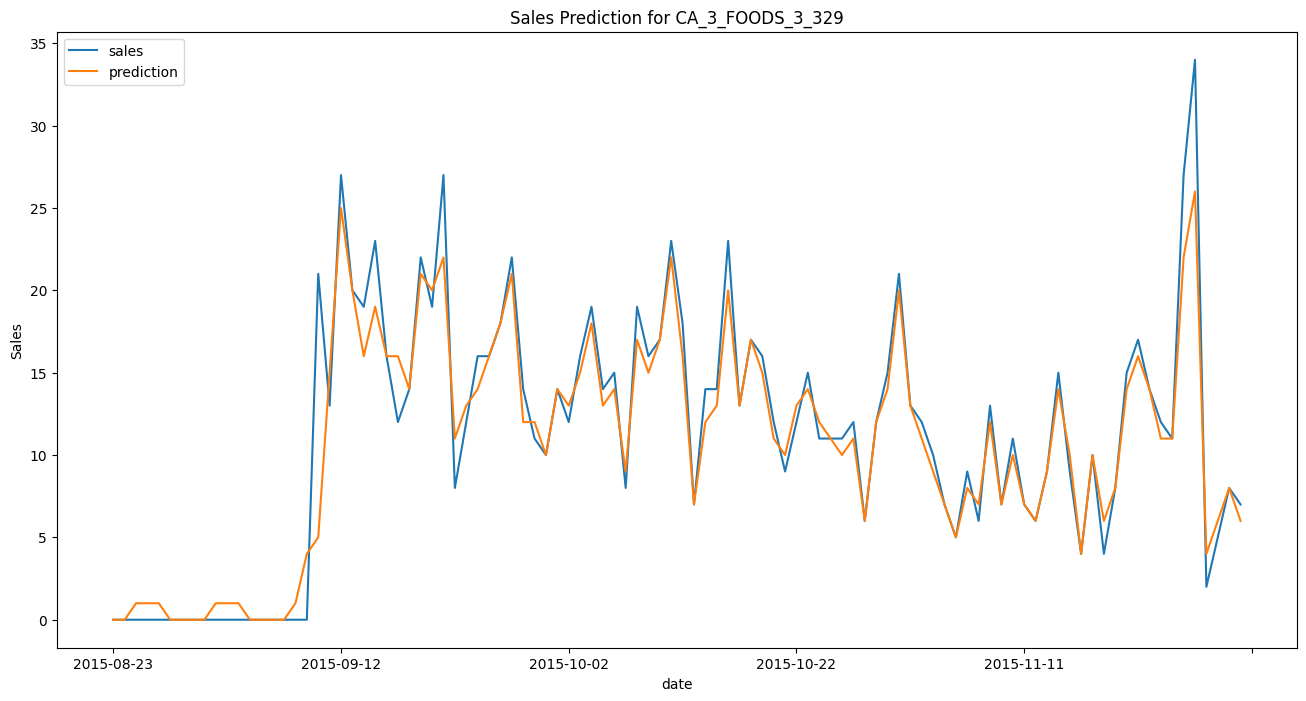

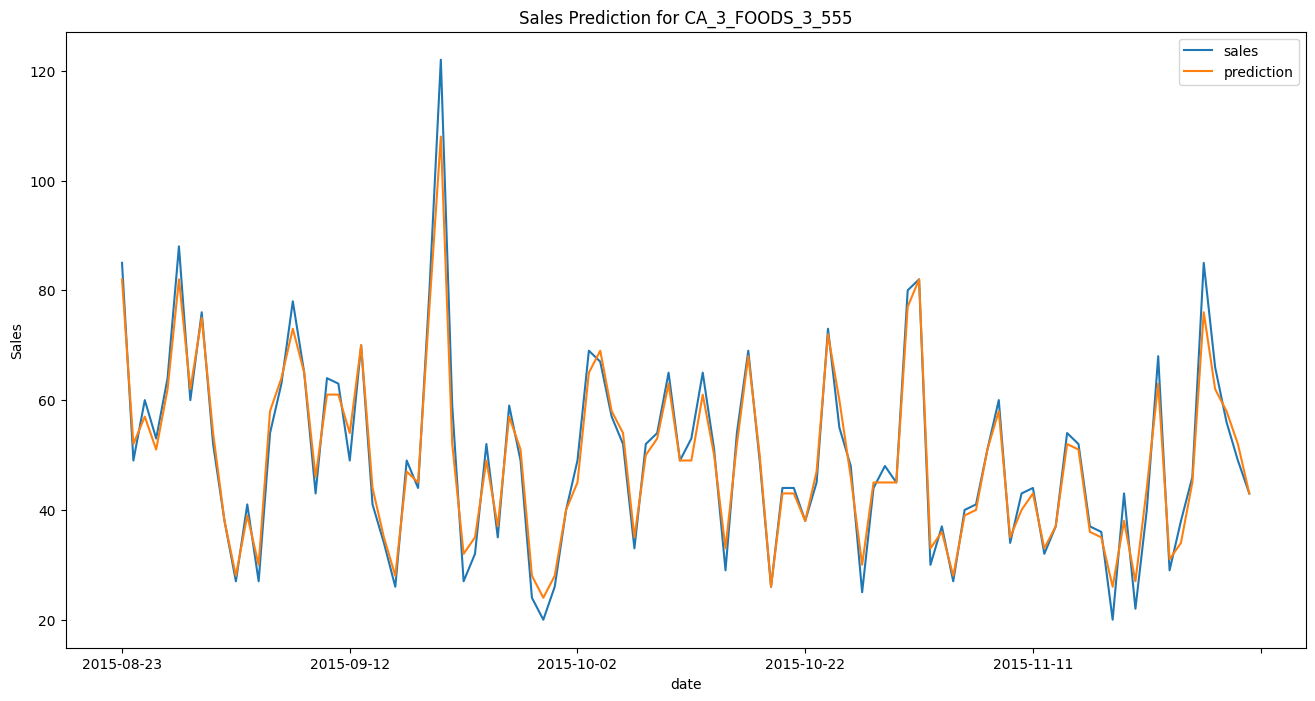

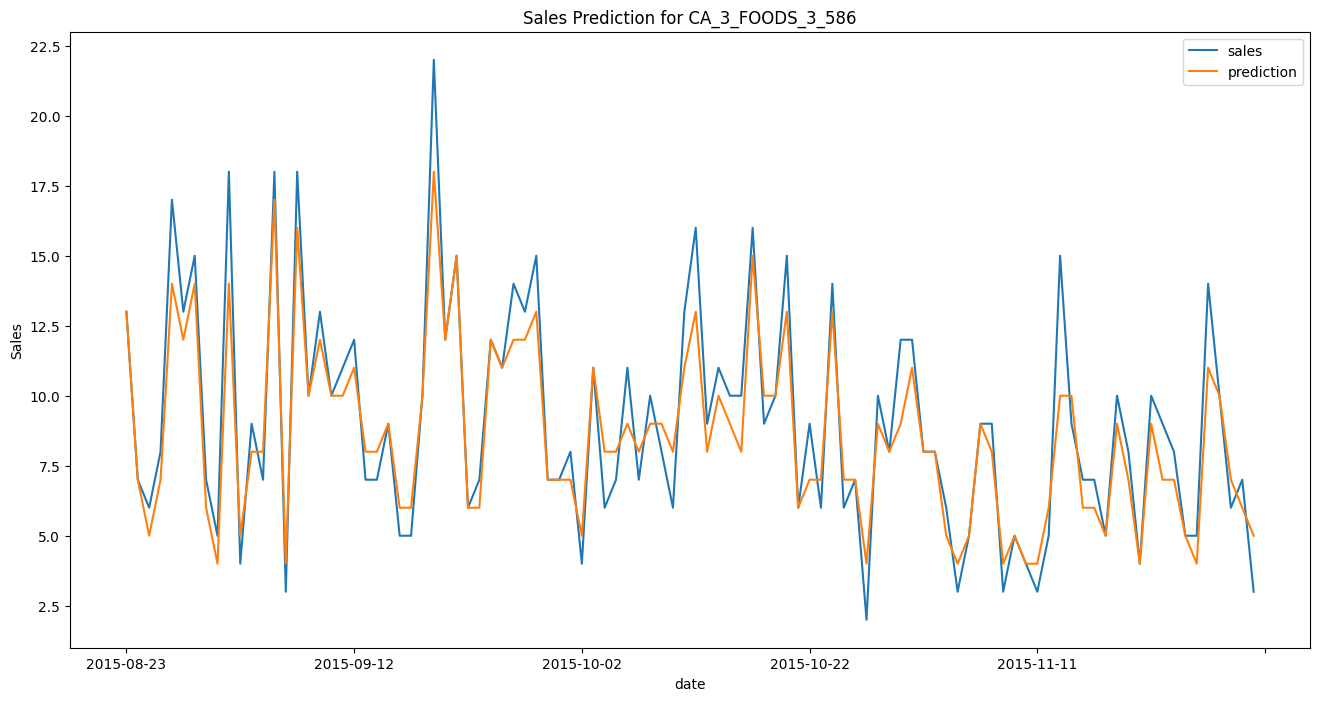

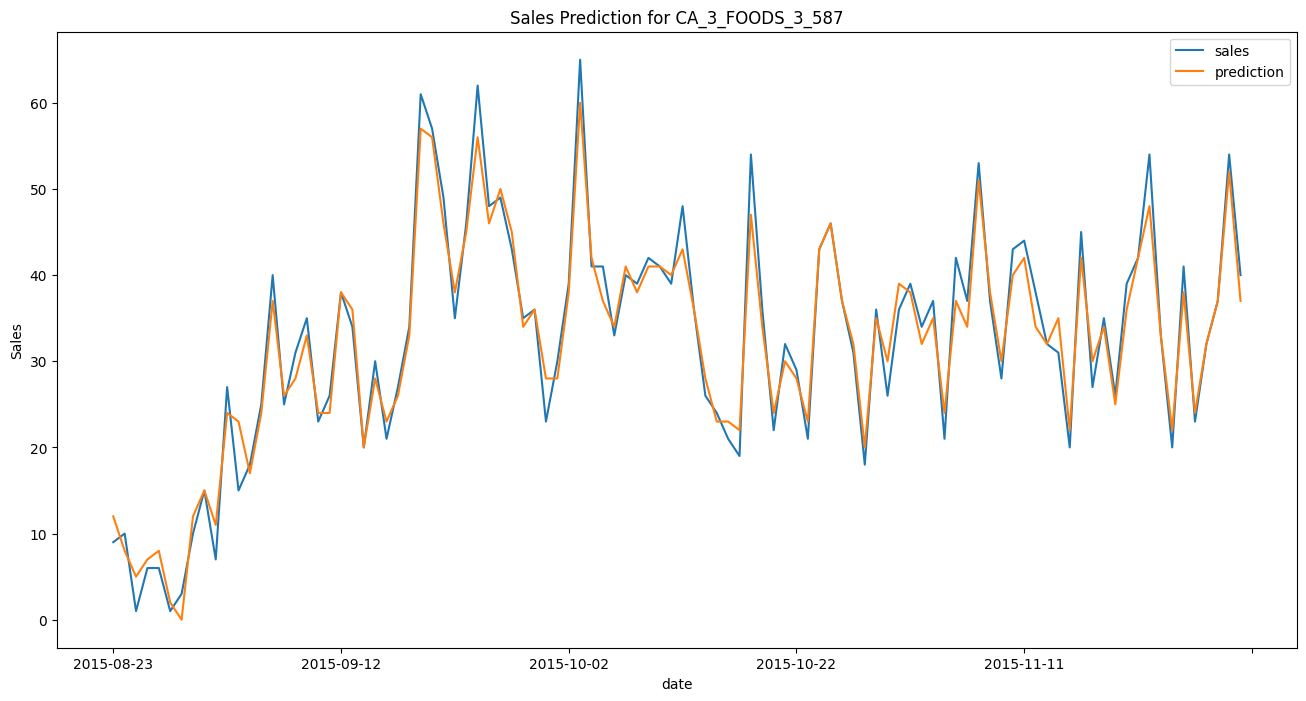

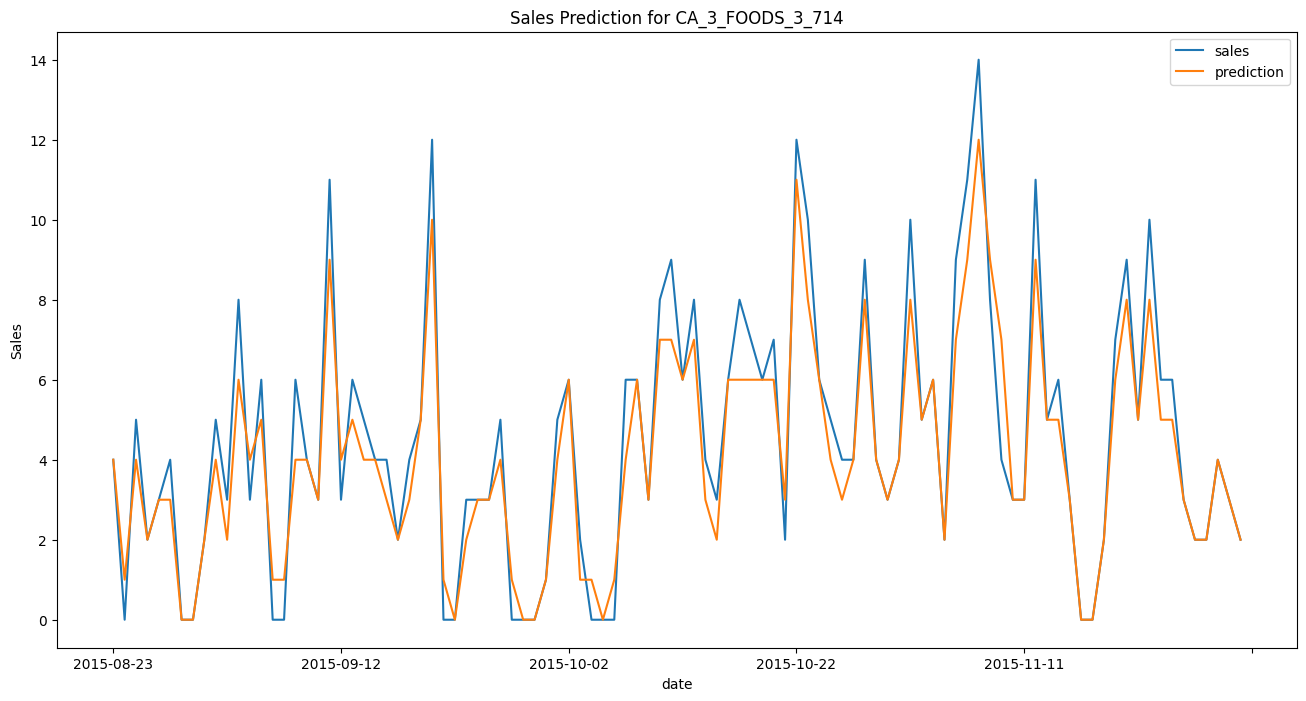

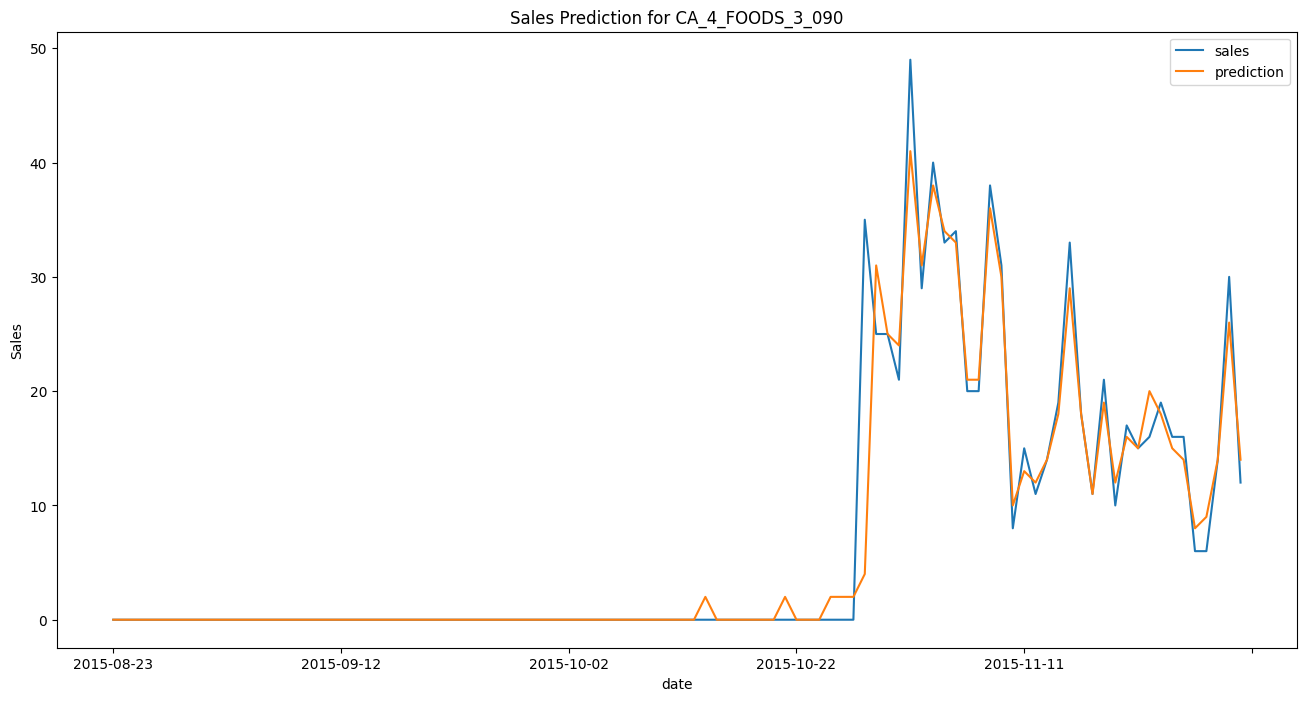

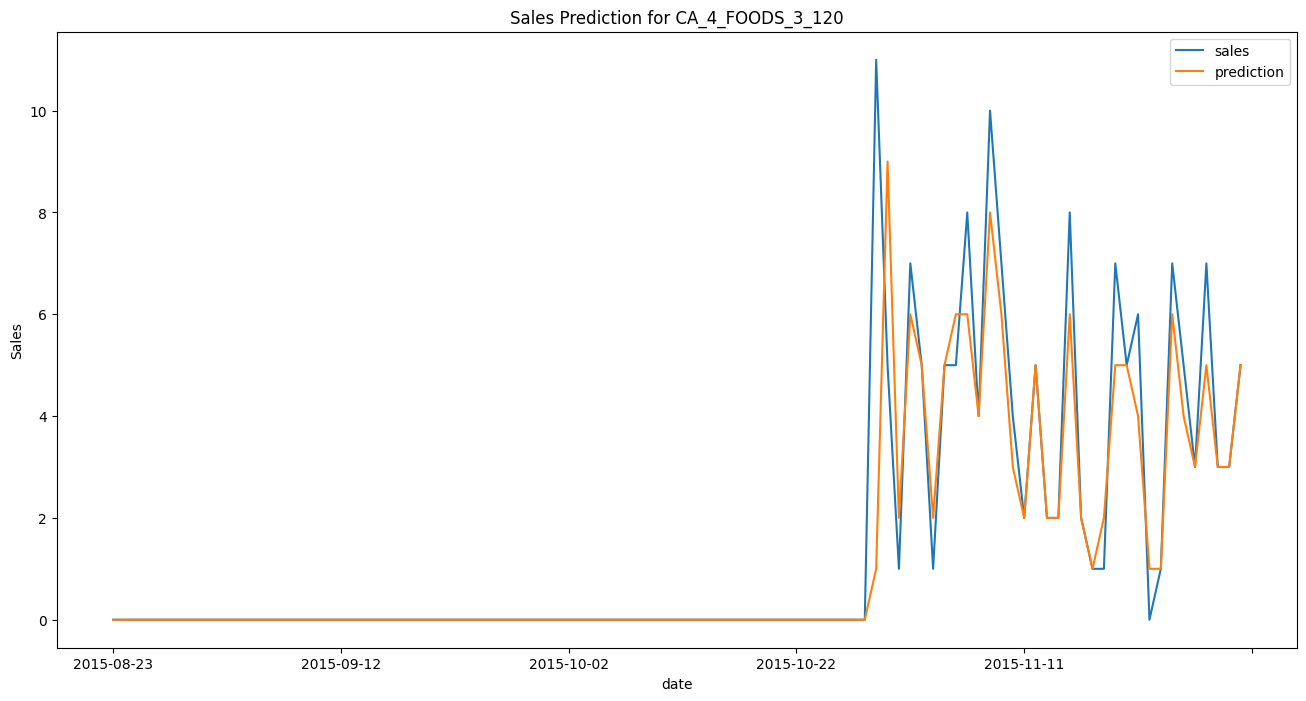

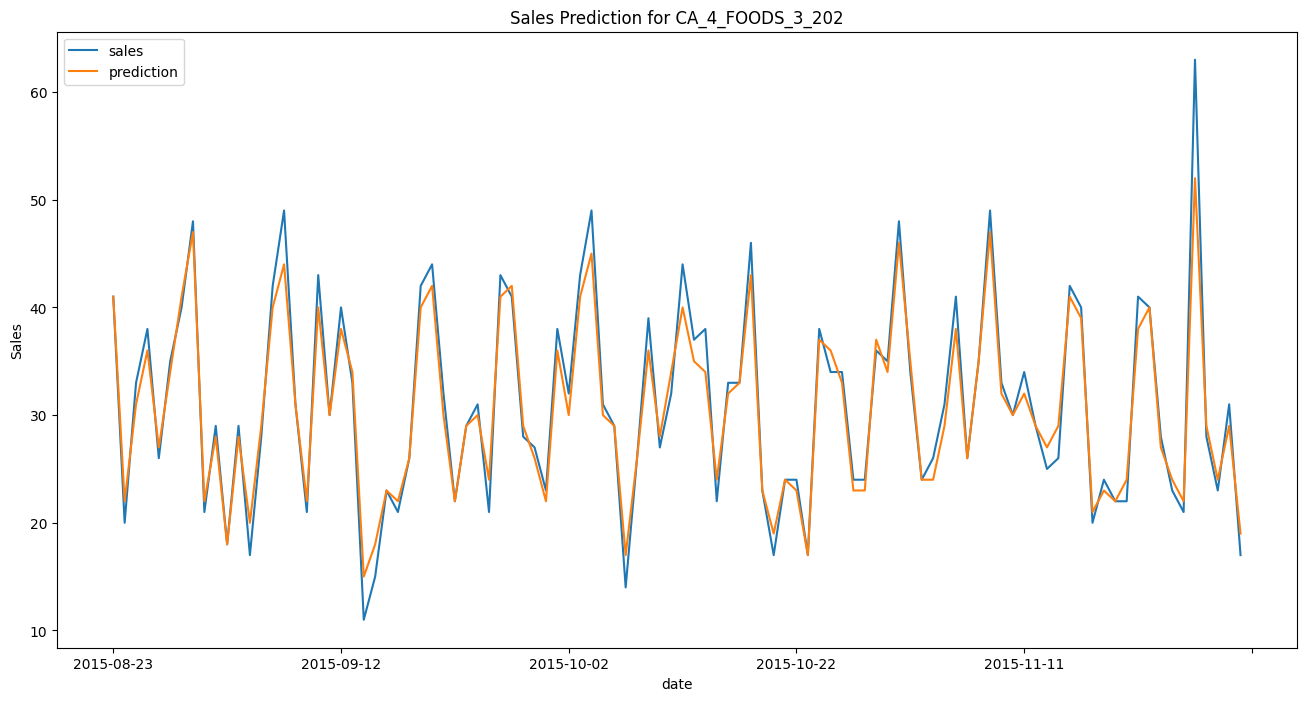

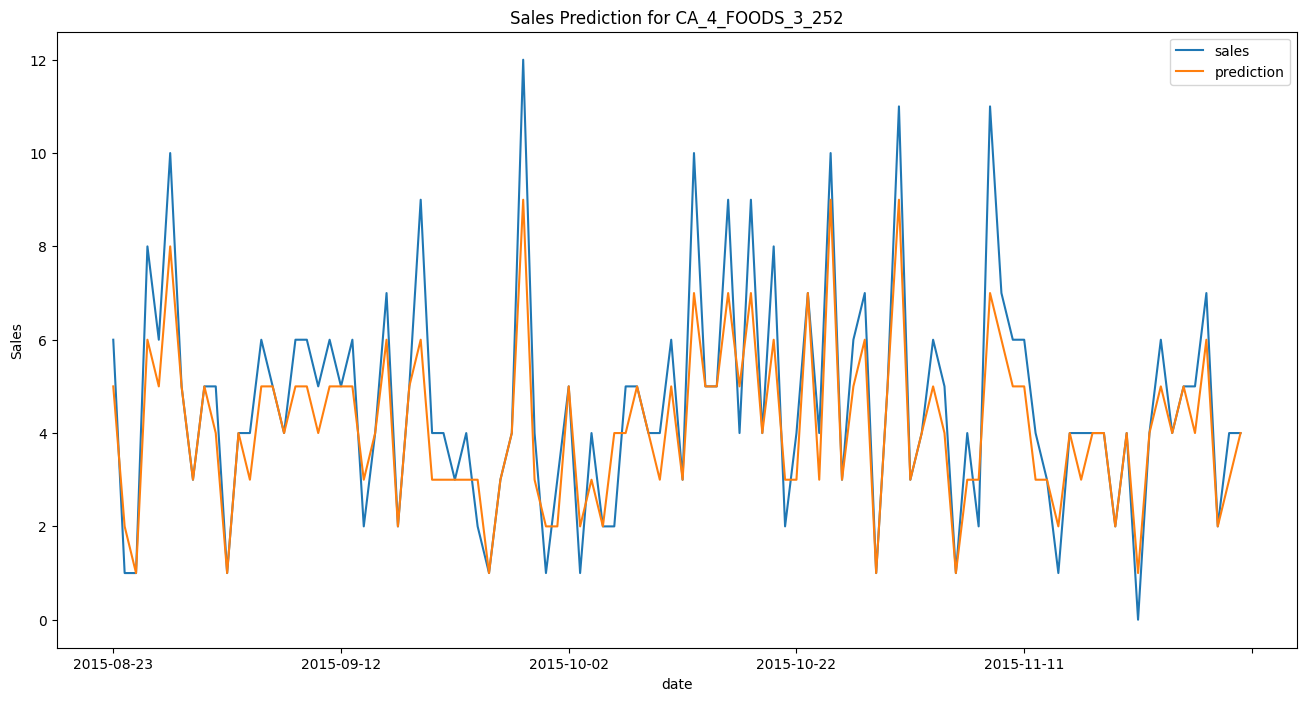

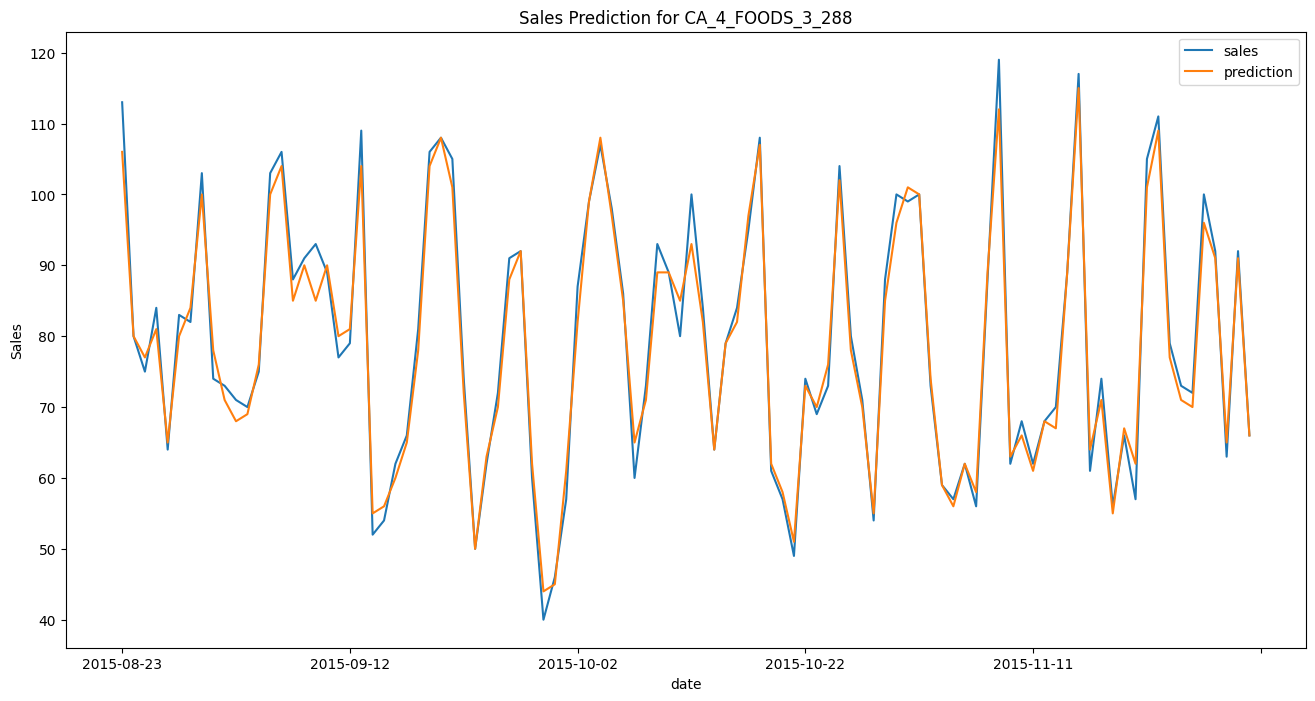

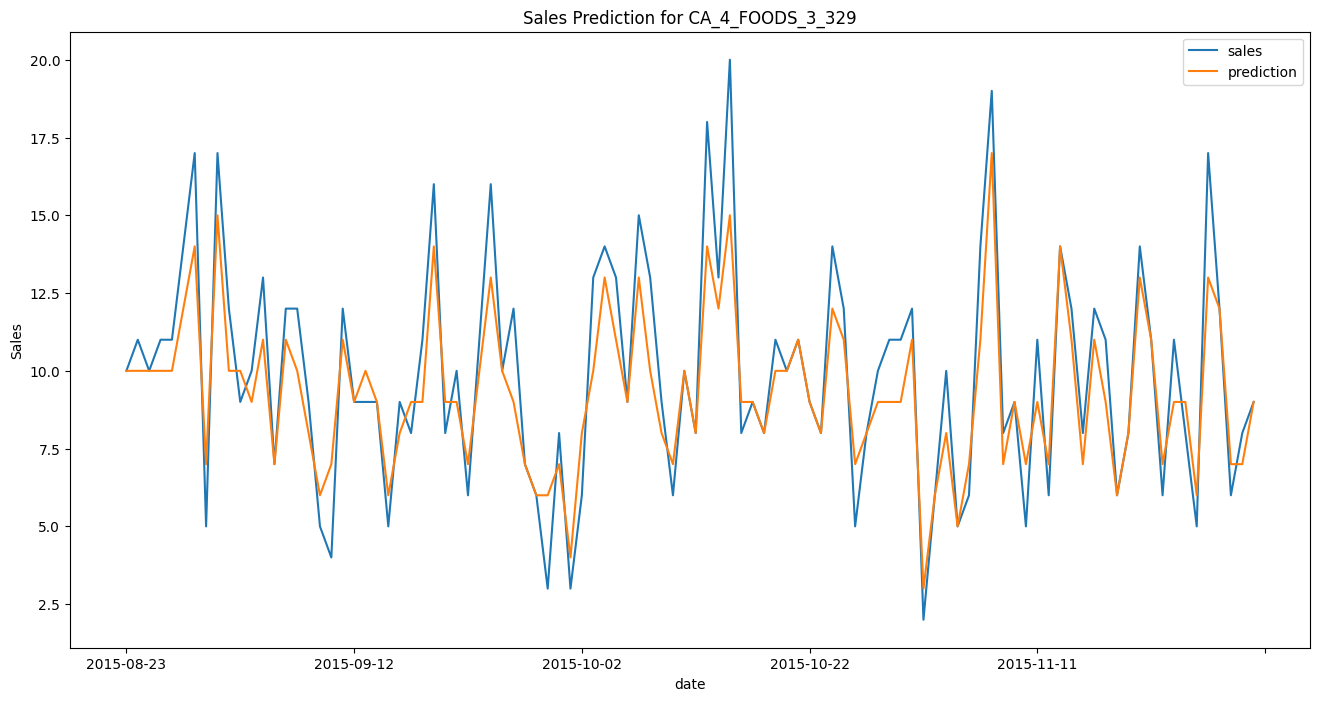

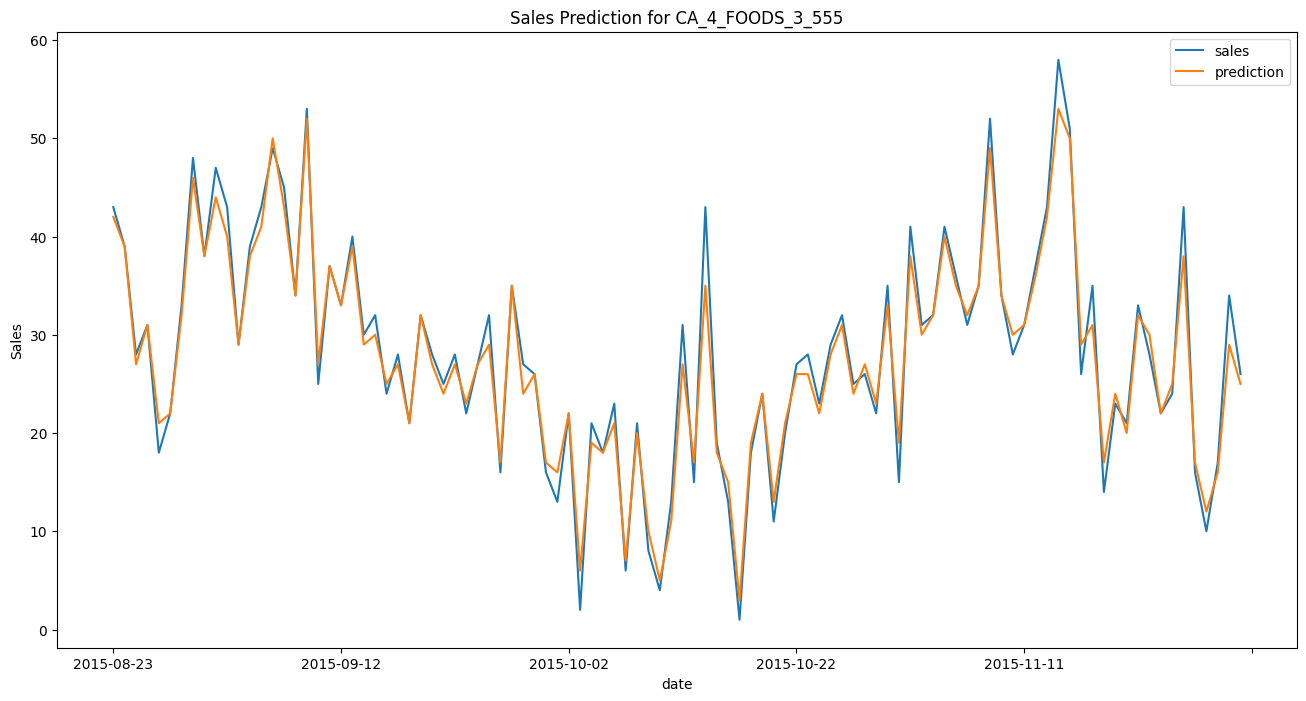

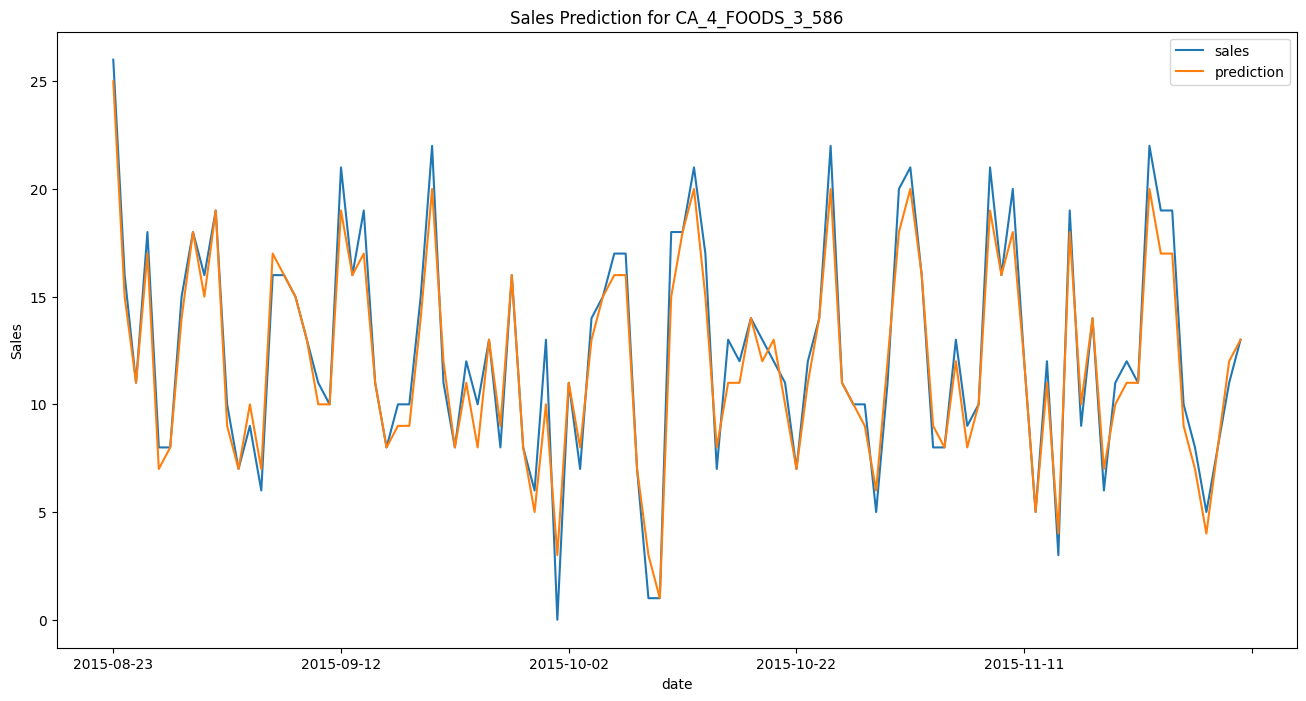

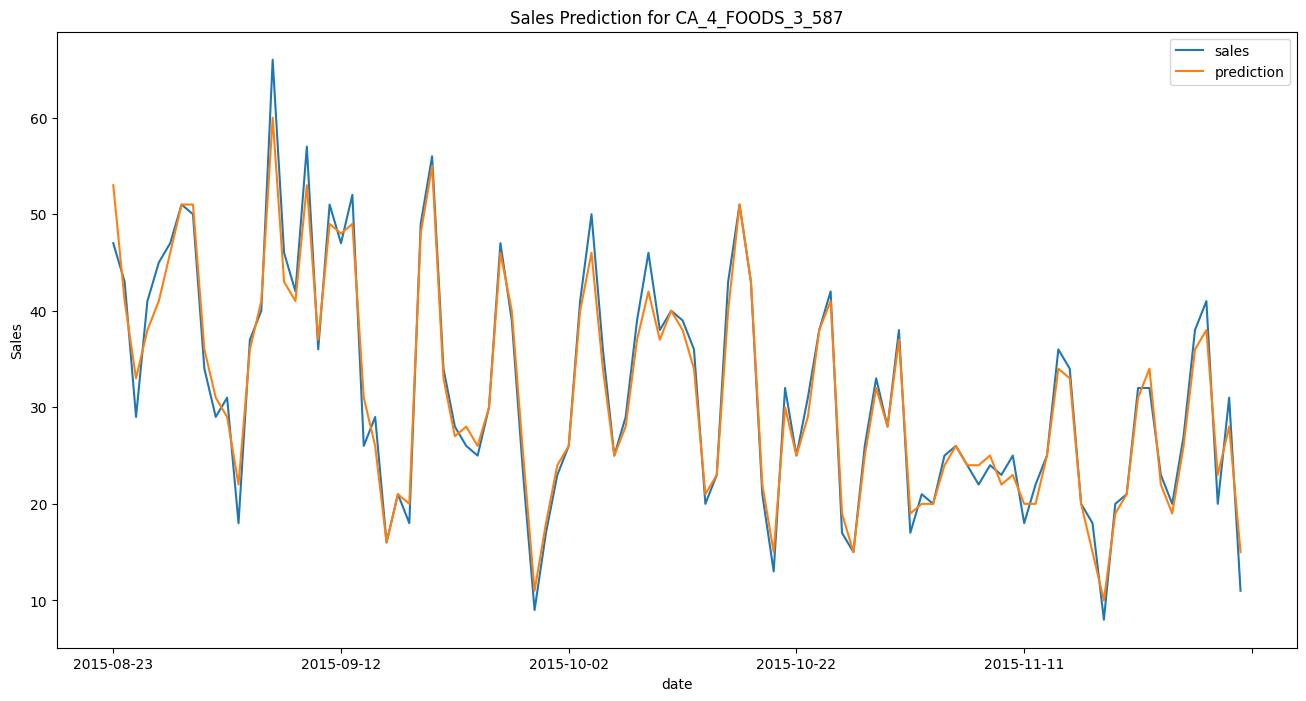

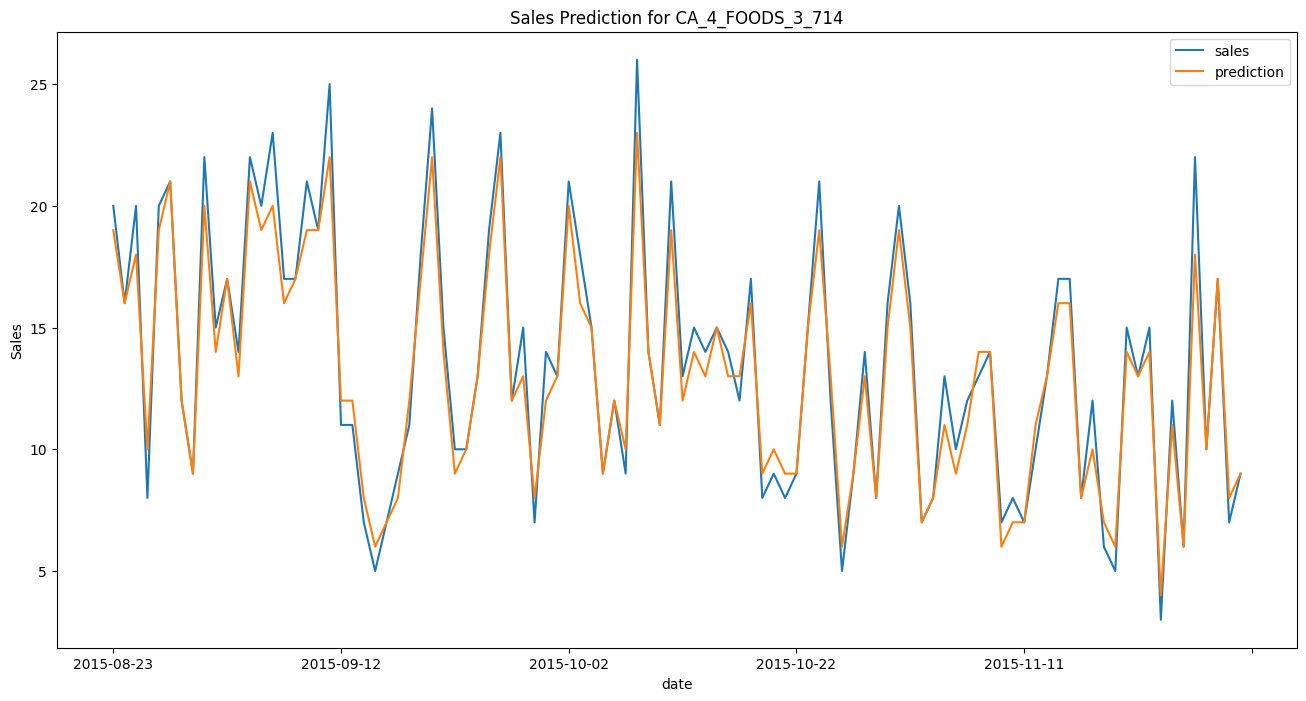

In [ ]:
# 2. Iterate through each model in our models_list
for i in range(0, len(models_list)):
    # Extract the product name and model
    product = models_list[i][0]
    model = models_list[i][1]
    
    # Get the feature names from the model
    variables = model.named_steps['algorithm'].feature_names_in_
    
    # 3. Prepare the data for this specific product
    # Create mask for filtering
    product_mask = df['product'] == product
    
    # Get X data (features) - only drop the 'sales' column
    x_prod = df[product_mask].drop(columns=['sales']).copy()
    
    # Get y data (target)
    y_prod = df[product_mask]['sales'].copy()
    
    # Get dates for plotting
    date = x_prod['date'].values
    
    # 4. Make predictions and create visualization DataFrame
    predictions = pd.DataFrame({
        'date': date,
        'product': product,
        'sales': y_prod,
        'prediction': model.predict(x_prod[variables])
    })
    
    # Convert predictions to integers
    predictions['prediction'] = predictions['prediction'].astype('int')
    
    # Set date as index for plotting
    predictions.set_index('date', inplace=True)
    
    # 5. Create the plot
    ax = predictions.tail(100)[['sales', 'prediction']].plot(
        figsize=(16, 8),
        title=f'Sales Prediction for {product}'
    )
    ax.set_ylabel('Sales')
    plt.show();

In [61]:
# Load validation data
validation_data = pd.read_parquet(VALIDATION_DIR / 'validation.parquet')
validation_data

state_id store_id  dept_id cat_id      item_id  wm_yr_wk       d  \
date                                                                          
2015-12-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_090     11544  d_1768   
2015-12-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_120     11544  d_1768   
2015-12-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_202     11544  d_1768   
2015-12-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_252     11544  d_1768   
2015-12-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_288     11544  d_1768   
...             ...      ...      ...    ...          ...       ...     ...   
2015-12-31       CA     CA_4  FOODS_3  FOODS  FOODS_3_329     11548  d_1798   
2015-12-31       CA     CA_4  FOODS_3  FOODS  FOODS_3_555     11548  d_1798   
2015-12-31       CA     CA_4  FOODS_3  FOODS  FOODS_3_586     11548  d_1798   
2015-12-31       CA     CA_4  FOODS_3  FOODS  FOODS_3_587     11548  d_1798   
2015-12-31       CA     CA_4  FOODS_3  FOODS  FOODS_3_714     11548  d_1798   

            sales  sell_price  year  month  wday   weekday event_name_1  \
date                                                                      
2015-12-01     57        1.50  2015     12     4   Tuesday         None   
2015-12-01    109        4.98  2015     12     4   Tuesday         None   
2015-12-01     17        4.58  2015     12     4   Tuesday         None   
2015-12-01     29        1.58  2015     12     4   Tuesday         None   
2015-12-01     25        1.50  2015     12     4   Tuesday         None   
...           ...         ...   ...    ...   ...       ...          ...   
2015-12-31      6        2.98  2015     12     6  Thursday         None   
2015-12-31      5        1.68  2015     12     6  Thursday         None   
2015-12-31     11        1.68  2015     12     6  Thursday         None   
2015-12-31     16        2.48  2015     12     6  Thursday         None   
2015-12-31     21        1.58  2015     12     6  Thursday         None   

           event_type_1 event_name_2 event_type_2  
date                                               
2015-12-01         None         None         None  
2015-12-01         None         None         None  
2015-12-01         None         None         None  
2015-12-01         None         None         None  
2015-12-01         None         None         None  
...                 ...          ...          ...  
2015-12-31         None         None         None  
2015-12-31         None         None         None  
2015-12-31         None         None         None  
2015-12-31         None         None         None  
2015-12-31         None         None         None  

[620 rows x 17 columns]